In [1]:
from pyemd import emd 
from sklearn.feature_extraction import stop_words
from scipy.optimize import curve_fit
from nltk.corpus import reuters
from sklearn.manifold import TSNE
from sklearn import decomposition
from sklearn.externals.joblib import Parallel, delayed
from sklearn import mixture
import seaborn as sns
from sklearn.preprocessing import normalize
import pickle
import random
from sklearn.neighbors import KNeighborsClassifier, BallTree
from sklearn.metrics import accuracy_score, classification_report
import gensim, math
import time
import pandas as pd
import nltk 
from os.path import dirname, abspath
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, cosine_distances
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from nltk.corpus import stopwords
import lda
import numpy as np
import gensim
from nltk import word_tokenize
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import string
import os
from scipy.spatial.distance import cosine
from gensim.matutils import softcossim
from scipy.sparse import csc_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import mixture
from collections import Counter
import sklearn.metrics as mt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

figure(num=None, figsize=(10, 8), dpi=70, facecolor='w', edgecolor='k')

# Load word embeddings

In [2]:
def load_glove():    
    print("Loading Glove model")
    f = open('../Benchmark/glove.840B.300d.txt', errors = "ignore")
    glove = {}
    for line in f:
        try:
            splitLine = line.split()
            word = splitLine[0]
            embedding = np.array([float(val) for val in splitLine[1:]])
            glove[word] = embedding
        except:
            pass
    print("Glove loading done.")
    return(glove)
def load_word2vec():
    print("Loading Word2vec model")
    word2vec = gensim.models.KeyedVectors.load_word2vec_format('../Benchmark/GoogleNews-vectors-negative300.bin', binary=True)
    print("Word2vec loading done")
    return word2vec
#glove = load_glove()
word2vec = load_word2vec()

Loading Word2vec model
Word2vec loading done


# Local embedding

In [8]:
def tokenize_corpus(data):
    tokenizer = CountVectorizer().build_analyzer()
    return [tokenizer(doc) for doc in data]
corpus = BBCNews.data
model = gensim.models.Word2Vec(
    tokenize_corpus(corpus),
    size=200,
    window=10,
    min_count=0,
    workers=4,
    sg = 1)
model.train(corpus, total_examples=len(corpus), epochs=100)
myvectors = model.wv
del model

# BBC news & BBC sport

In [3]:
class MyDataContainer(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    


def load_BBCNews(topics,folder):
    print("loading bbc news")
    tokenizer = CountVectorizer().build_analyzer()
    cwd = dirname(os.getcwd())+"/Data/"+folder
    BBCNews = MyDataContainer({'data': [],
               'target': []})
    index = 0
    for i, s in enumerate(topics):
        path = cwd+s
        ids = []
        for j, filename in enumerate(os.listdir(path)):
            ids.append(index)
            with open(path+"/"+filename, 'r', encoding="latin-1") as f:
                text = f.read() 
                #text = text+(" "+noises[noise_indices[counter]]+" ")*nn if add_noise else text
                BBCNews.data.append(text)
                BBCNews.target.append(i)
            f.close()
            index += 1 
        BBCNews[s] = ids
        print("{}: {} records".format(s, len(ids)))
    print("{} total records loaded".format(index))
    return BBCNews


topics_bbcnews = ["business", "entertainment", "politics", "sport", "tech"]
topics_bbcsport = ["athletics", "cricket","football","rugby","tennis"]
BBCNews = load_BBCNews(topics_bbcnews,"bbcnews/")
BBCSport = load_BBCNews(topics_bbcsport, "bbcsport/")

loading bbc news
business: 510 records
entertainment: 386 records
politics: 417 records
sport: 511 records
tech: 401 records
2225 total records loaded
loading bbc news
athletics: 101 records
cricket: 124 records
football: 265 records
rugby: 147 records
tennis: 100 records
737 total records loaded


# Reuters news

In [5]:
documents = reuters.fileids()
train_docs = list(filter(lambda doc: doc.startswith("train"),
                        documents));
test_docs = list(filter(lambda doc: doc.startswith("test"),
                       documents));
categories = reuters.categories();
category_docs = reuters.fileids("acq");

train_docs_id = list(filter(lambda doc: doc.startswith("train"), documents))
test_docs_id = list(filter(lambda doc: doc.startswith("test"), documents))

train_docs = [reuters.raw(doc_id) for doc_id in train_docs_id]
test_docs = [reuters.raw(doc_id) for doc_id in test_docs_id]


# 20 news

In [4]:
topics_news20 = [#'comp.graphics',
        #'comp.os.ms-windows.misc',
        'comp.sys.ibm.pc.hardware',
        'rec.autos',
        'rec.motorcycles',
        'rec.sport.baseball',
        'sci.crypt',
        #'sci.electronics',
        'sci.med']

news20_all = fetch_20newsgroups(categories=topics_news20)
news20_noise = random.sample(news20_all.data, len(BBCNews.data))
BBCNews_noised = MyDataContainer({"data": [a+b for a, b in zip(news20_noise, BBCNews.data)],
                            "label": BBCNews.label})
print(len(news20_all.data))

3568


# 20 news mixed

In [6]:
#pickle.dump(texts, open("sample_texts.pickle", "wb"))
texts = pickle.load(open("sample_texts.pickle", "rb"))

In [5]:
tokenizer = CountVectorizer().build_analyzer()
def within_sum_var(vecs):
    mean = np.mean(vecs, axis = 0)
    var = [np.sum(np.square(v-mean)) for v in vecs]
    return sum(var)
def within_cosine(vecs):
    if len(vecs) == 1:
        return 0
    mean = np.mean(vecs, axis = 0)
    similarity_matrix = cosine_similarity(vecs, [mean])
    return np.mean(similarity_matrix)
def logistic_cdf(x, mu,s):
    return 1/(1+np.exp(-(x-mu)/s))
def logistic_pdf(x, mu,s):
    return np.exp(-(x-mu)/s)/(s*(1+np.exp(-(x-mu)/s))**2)
def ecdf(data):
    n=len(data)
    x=np.sort(data)
    y=np.arange(1,n+1)/n
    return x, y

def epdf(data):
    n=len(data)
    x=np.sort(data)
    y=np.arange(1,n+1)/n
    return x, y

corpus = tokenizer(" ".join(BBCNews.data[:]))+tokenizer(" ".join(news20_all.data[:])) + tokenizer(" ".join(BBCSport.data[:]))#stop_words.ENGLISH_STOP_WORDS#stopwords.words("english")
#corpus = stop_words.ENGLISH_STOP_WORDS
vocabulary = list(set(corpus))
vocabulary = [word for word in vocabulary if word in word2vec]


#vec_c = np.mean([word2vec[word] for word in ["business", "the"]], axis = 0)
x = vocabulary
x_vecs = np.array([word2vec[t] for t in x])
vec_c = word2vec["the"]
dist = cosine_similarity(x_vecs, [vec_c])
#dist = x_vecs.dot(np.array(vec_c))
dist = dist.ravel()
res = zip(dist, x)
sort_res = sorted(res,key=lambda res:res[0], reverse=True)
sorted_scores = np.array([s for s, _ in sort_res])
sorted_words = np.array([w for _, w in sort_res])

print("min:{}; max:{}; mean:{}".format(min(sorted_scores), max(sorted_scores), np.mean(sorted_scores)))
vocab_all = list(word2vec.vocab.keys())
vec_all = [word2vec[word] for word in vocab_all]
#dist = cosine_similarity(vec_all, [vec_c_all])
#vec_c_all = np.mean([word2vec[word] for word in vocab_all], axis = 0)
#scores_all = sorted([word2vec.similarity(word,"the") for word in vocab_all])
#scores_all = sorted(dist.ravel())
#sns.kdeplot(sorted_scores, label = "pdf")
def my_distplot(scores, step, cdf_p, pdf_p, fit, allwords):
    if allwords:
        figure(num=None, figsize=(8, 6), dpi=70, facecolor='w', edgecolor='k')
        ec, ey = ecdf(scores)
        popt_cdf, pcov_cdf = curve_fit(logistic_cdf, ec, ey)
        print("mu:{} s:{}".format(popt_cdf[0],popt_cdf[1]))
        plt.plot(ec, logistic_cdf(ec, *popt_cdf), 'g--', label='fitted cdf google', color = "red")
        plt.plot(ec,ey, label = "cdf google", color = "blue")
        plt.xlabel("X")
        plt.ylabel("probability")
        plt.legend()
    else: 
        xr = np.arange(min(scores), max(scores)+step,step)
        cdf = []
        pdf = []
        for thresh in xr:
            count = sum(scores<=thresh)
            cdf.append(count/len(scores))
            pdf.append((count - sum(scores < thresh-step))/len(scores))
        popt_cdf, pcov_cdf = curve_fit(logistic_cdf, xr, cdf)
        popt_pdf, pcov_pdf = curve_fit(logistic_pdf, xr, pdf)
        print("mu:{} s:{}".format(popt_cdf[0],popt_cdf[1]))
        #figure(num=None, figsize=(8, 6), dpi=70, facecolor='w', edgecolor='k')
        if fit:
            plt.plot(xr, logistic_cdf(xr, *popt_cdf), 'g--', label='fitted cdf dataset')
            #plt.plot(xr, logistic_pdf(xr, *popt_cdf), 'g--', label='fitted pdf')
        if cdf_p:
            plt.plot(xr, cdf, label = "cdf dataset")
        if pdf_p:
            plt.plot(xr, pdf, label = "pdf dataset")
        plt.xlabel("X")
        plt.ylabel("probability")
        plt.legend()
        
my_distplot(scores_all, step = 0.02, cdf_p = True, pdf_p = True, fit = True, allwords = True)   
my_distplot(sorted_scores, step = 0.02, cdf_p = True, pdf_p = False, fit = True, allwords = False)   
plt.show()
#plt.plot(xr, percents)
#plt.xlabel("cosine similarity")
#plt.ylabel(r"$\alpha$")
#plt.show()
#print([w for s,w in sort_res if s > 0.65 and w in swords])
#df = pd.DataFrame(dict(x = np.arange(0,1,0.005), score=percents))

#sns.lmplot("x",'score', data=df, fit_reg=False)




min:-0.24397407472133636; max:1.0; mean:0.066214919090271


NameError: name 'scores_all' is not defined

[('economics', 0.3639267202310662), ('airplane', 0.39281145018332908), ('truck', 0.58965783559601559), ('car', 0.43794753789371954), ('finance', 0.48790377234838589), ('blue', 0.024595525417733022), ('laptop', 0.72507011769597973), ('graphics', 0.49475569739568459), ('cow', 0.22831477702171166), ('denotation', 0.038035235940165335), ('capitalism', 0.12361781656609494), ('purple', 0.060796526108818472), ('is', 0.0013283816461689968), ('he', 0.00051040770649457556), ('therefore', 0.0021622673962751193), ('however', 4.4120838200822909e-05), ('also', 0.0003010570710381133)]
lennox, chum, jf, metabolizes, pathogens, bbb, duced, syracuse, immaculately, diabetic, briggs, gaddafi, elisa, appliances, nadal, carbonated, aggregator, moore, saul, sidekick
0.867989229812


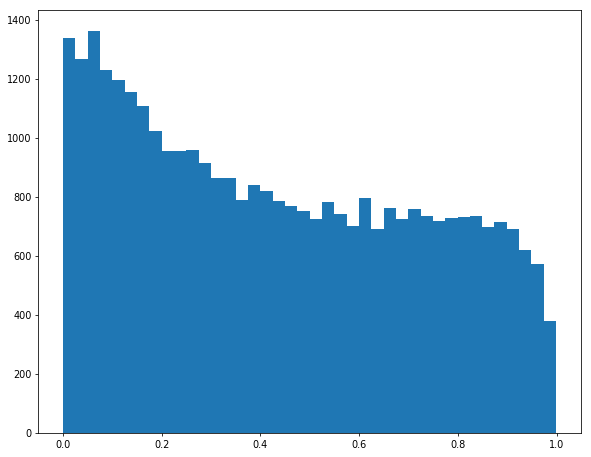

In [6]:
def importance(score):
    return np.clip(1-1/(1+np.exp((0.048-score)/0.0425)),0,1)
def importance_words(words):
    vecs = [word2vec[word] for word in words]
    dist = cosine_similarity(vecs, [word2vec["the"]]).ravel()
    return [np.clip(1-1/(1+np.exp((0.04845-score)/0.042517)),0,1) for score in dist]

def importance_vecs(vecs):
    scores = cosine_similarity(vecs, [word2vec["the"]]).ravel()
    importances = [np.clip(1-1/(1+np.exp((0.04845-score)/0.042517)),0,1) for score in scores]
    #print("len vecs{} len importances{}".format(len(scores),len(importances)))
    return importances
def importance_all(scores):
    importances = [np.clip(1-1/(1+np.exp((0.066-score)/0.0444)),0,1) for score in scores]
    return importances
importances = [importance(score) for score in sorted_scores]
stopwords_w2v = [word for word in stop_words.ENGLISH_STOP_WORDS if word in word2vec]
stopwords_w2v_imp = importance_words(stopwords_w2v)
nonstopwords_w2v = ["economics", "airplane", "truck", "car","finance","blue","laptop","graphics",
                    "cow","denotation", "capitalism", "purple",
                   "is","he","therefore","however","also"]
nonstopwords_w2v_imp = importance_words(nonstopwords_w2v)
print(list(zip(nonstopwords_w2v, nonstopwords_w2v_imp)))
ix = [i for i, score in enumerate(sorted_scores) if  -1<score<0]
thosewords = [sorted_words[i] for i in ix]
samplewords = random.sample(thosewords, 20)
print(", ".join(samplewords))
print(np.mean([importances[i] for i in ix]))
plt.hist(importances, bins = 40)
plt.show()
#print(", ".join(sorted_words[:50]))

Saint-Andre anger at absent stars

Sale Sharks director of rugby Philippe Saint-Andre has re-opened rugby's club-versus-country debate.

Sale host Bath in the Powergen Cup on Friday, but the Frenchman has endured a "difficult week" with six players away on England's Six Nations training camp. "It's an important game but we've just the one full session. It's the same for everyone but we need to manage it. "If five players or more are picked for your country they should move the date of the game," he told BBC Sport. Unless the authorities agree to make changes, Saint-Andre believes England's national team will suffer as clubs opt to sign foreigners and retired internationals. "That's not good for the politics of the English team or for English rugby," he argues. It is an issue he has taken up before, most notably during the autumn internationals when Sale lost all three Zurich Premiership matches they played.

Now he fears it could derail the club's hopes of cup silverware after eight pl

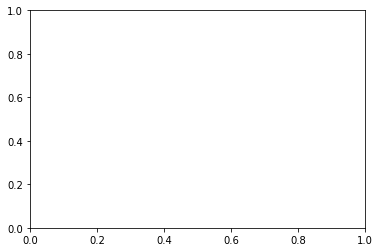

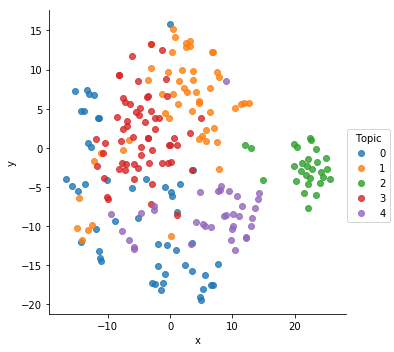

[ 0.00850465  0.07080709  0.30348255  0.48665821  0.1305475 ]
label: 0
size: 8
weight: 0.008504645761404427
importance: 0.08833039254851778
nSize: 0.01951219512195122
carried, carrying, taken, knocked, damaged, authorities, white
label: 1
size: 94
weight: 0.07080709013153781
importance: 0.04712317174709264
nSize: 0.22926829268292684
for, six, in, three, before, five, eight, after, plus, or, with, make, than, their, final, half, during, were, be, second, end, on, including, will, more, are, need, up, versus, at, unless, return, full, home, result, requires, quarter, date, opt, sign, hopes, host, manage, fly, derail, opened, medical, cherry, sale, bath
label: 2
size: 34
weight: 0.3034825527313247
importance: 0.6195643350660508
nSize: 0.08292682926829269
england, nigel, andre, charlie, daniel, jason, james, europe, france, robinson, january, bruno, scotland, bristol, bbc, english, friday, simpson, ll, thursday, ve
label: 3
size: 231
weight: 0.4866582079012081
importance: 0.106445461121149

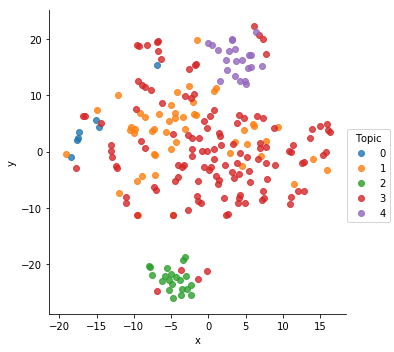

ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

In [148]:
doc = "Economics, economy, finance, capitalism, macroeconomics, money, consumer, euro, dollar, bank, rich, \
Dog, cat, goat, cow, horse,sheep, chicken, rabbit, fox,tiger,\
Red, orange, yellow, green,blue, purple, white, black,\
Football, basketball, baseball, tennis, swimming, archery,\
Denote, denotes, denotation,denoted, denoting, \
about, above, because, between, could, from, where,under, until, their, same, is, through, after, each,\
fashion, design, dressing, designer, stylish, artistic"
it1 = "Dog, cat, goat, cow, horse, sheep,chicken, rabbit, fox, tiger,\
Economics, economy, finance,capitalism, macroeconomics,money, consumer, euro, dollar,bank,\
Red, orange, yellow, green,blue, purple, white, black,pink, brown"

it2 = "Economics, economy, finance,capitalism, macroeconomics, money, consumer, euro, dollar,bank, rich,\
Dog, cat, goat, cow, horse,sheep, chicken, rabbit, fox, tiger,\
Red, orange, yellow, green,blue, purple, white, black,\
Football, basketball, baseball,tennis, swimming, archery,\
Denote, denotes, denotation,denoted, denoting,\
about, above, because, between,could, from, where, under,until, their, same, is,through, after, each, \
however, as, perhaps, therefore,\
fashion, design, dressing,designer, stylish, artistic"

it3 = "Blunkett hints at election call Ex-Home secretary David Blunkett has given fresh clues that the general election will be announced on Monday. He told BBC\
 Radio Five Live: I'm out in my constituency getting ready for what we presume will\
 be an announcement very shortly at the weekend. He clarified that he meant he would\
 be in his Sheffiled seat this weekend, not that he expected an election call then. \
 Tony Blair is tipped to ask the Queen on Monday to dissolve Parliament ready for a 5 \
 May poll."

it4 = "Lacroix label bought by US firm\
 Luxury goods group LVMH has sold its loss-making Christian Lacroix clothing label to a US investment group.\
 The Paris-based firm has been shedding non-core businesses and focusing on its most profitable brands including\
 Moet Chandon champagne and Louis Vuitton. LVMH said the French designer's haute couture and ready-to-wear labels\
 had been purchased by the Falic Group for an unspecified sum. The Falic Group bought two cosmetics labels from LVMH\
 in 2003. The sale of the Lacroix label comes as many fashion houses are struggling to make money from their expensive\
 haute couture ranges. The Florida-based Falic group, which also runs a chain of 90 duty free stores in the US, said\
 it planned to expand the brand by opening new stores. Mr Lacroix said he planned to stay at the label he founded in\
 1987 although exact details are still to be confirmed ."
def within_var(vecs):
    mean = np.mean(vecs, axis = 0)
    var =[np.sum(np.square(v-mean)) for v in vecs]
    return sum(var)
def within_std(vecs):
    mean = np.mean(vecs, axis = 0)
    var = [np.sqrt(np.sum(np.square(v-mean))) for v in vecs]
    var = np.sum(var)/len(var)
    return var

def within_cosine(vecs):
    if len(vecs) == 1:
        return 0
    mean = np.mean(vecs, axis = 0)
    similarity_matrix = cosine_similarity(vecs, [mean])
    return np.mean(similarity_matrix)
swords_str = " ".join(stopwords.words("english"))
label1 = ["animals"]*10 + ["economics"]*10+["colors"]*10
label2 = ["economics"]*11+["animals"]*10+["colors"]*8+["sports"]*6+["variations"]*5 + ["stopwords"]*19 + ["fashion"]*6
wordembedding = word2vec
label = label1
def test( dataset, doc_id, synthetic, stop_words, n_clusters, loop, vis, unique,models, groundtruth):
    text = it3 if synthetic else dataset[doc_id]
    print(dataset[doc_id])
    tokenizer = CountVectorizer(stop_words = "english").build_analyzer() if stop_words else CountVectorizer().build_analyzer() 
    text = tokenizer(text)
    
    print("Length of document: {}".format(len(text)))
    text = [t for t in text if t in wordembedding]
    word_counter = Counter(text)
    word_counts = np.array(list(word_counter.values()))
    unique_text = np.array(list(word_counter.keys()))
    vecs = np.array([wordembedding[w] for w in unique_text])
    num_clusters = n_clusters if n_clusters > 0 else math.floor(np.log(len(unique_text)))
    print("# clusters: {}".format(num_clusters))
    print("# unique words: {}".format(len(vecs)))
    results_sil = []
    results_var = []
    for model in models:
        sil_coef = []
        sum_var = []
        similarity_matrix = cosine_similarity(vecs).clip(0,1)
        #print(similarity_matrix)
        n_clusters_loop = range(2, 2*num_clusters+1) if loop else range(num_clusters, num_clusters+1)
        for i in n_clusters_loop:
            if model == "kmeans":
                sc = KMeans(n_clusters = i, precompute_distances = True, 
                            n_init = 10, max_iter = 1000, algorithm = "full")
                sc.fit(vecs)
                distance_matrix = cosine_distances(vecs)
                #within_var.append(sc.inertia_)
            elif model == "spectral":
                sc = SpectralClustering(i, affinity='precomputed', 
                                        assign_labels = "discretize", 
                                        n_init=10)     
                sc.fit(similarity_matrix)
                distance_matrix = cosine_distances(vecs)
            elif model == "dbscan":
                sc = AgglomerativeClustering(
                                            n_clusters=i).fit(vecs)
                distance_matrix =  2-similarity_matrix
            elif model == "ggm":
                dpgmm = mixture.BayesianGaussianMixture(n_components=num_clusters, covariance_type='full').fit(vecs)
                sc.labels_ = dpgmm.predict(vecs)
                distance_matrix =  2-similarity_matrix
            
            #sc.labels = random.choices(range(num_clusters), k = len(vecs))
            silhoutte_score = silhouette_score(distance_matrix, sc.labels_, metric = 'precomputed')
            non_empty_clusters = np.array(list(set(sc.labels_)))
            indices = [np.where(sc.labels_ == j) if j in non_empty_clusters 
                                                               else [] for j in range(i)]
            sizes = [sum(word_counts[indices[j]]) for j in non_empty_clusters]
            weightings =np.array([ sum(importance_vecs(vecs[indices[j]]))/len(indices[j])*np.log(sizes[j])  for j in non_empty_clusters])
            weightings = weightings/sum(weightings)
            print(weightings)
            sil_coef.append(silhoutte_score)
            
            if model == "spectral" or model == "kmeans":
                a = 0
            withinsumvar = 0
            for j in non_empty_clusters: 
                words = unique_text[indices[j]].tolist()
                centroid = np.mean(vecs[indices[j]], axis = 0)
                dist = cosine_similarity(vecs[indices[j]], [centroid])
                res = zip(dist, words)
                sort_res = sorted(res,key=lambda res:res[0], reverse=True)
                words_sorted = [t for _, t in sort_res]
                print("label: {}".format(j))
                print("size: {}".format(sizes[j]))
                print("weight: {}".format(weightings[j]))
                print("importance: {}".format(sum(importance_vecs(vecs[indices[j]]))/len(vecs[indices[j]])))
                print("nSize: {}".format(sizes[j]/sum(sizes)))
                print(", ".join(words_sorted[:]))
                withinsumvar = withinsumvar + within_var(vecs[indices[j]])
                #print(", ".join(words_sorted[:]))
            sum_var.append(withinsumvar)
            if vis == "tsne":
                X_embedded = TSNE(n_iter = 1000,
                          metric = "precomputed").fit_transform(distance_matrix)
            else:
                X_embedded = decomposition.PCA(n_components=2, svd_solver = "full").fit_transform(vecs)
            df = pd.DataFrame(X_embedded)
            df['Topic'] = label if groundtruth else sc.labels_
            df.columns = ['x', 'y', 'Topic']
            #df.columns = ['x', 'y']
            sns.lmplot(x="x", y="y", hue = 'Topic', data=df, fit_reg=False, legend=True)
            #sns.lmplot(x="x", y="y", data=df, fit_reg=False)
            plt.show()
            #print("*"*20)
        results_sil.append(sil_coef)
        results_var.append(sum_var)
    #print(text)
    #print(label)
    #print(sc.labels_.tolist())
    ##df['label'] = sc.labels_.tolist()
    #df.columns = ['x', 'y', 'label']
    #sns.lmplot(x="x", y="y", data=df, fit_reg=False, hue='label', legend=False)
    #plt.show()
    #x = loop
    ##plt.plot(x,results_var[0],linestyle="-.", color = "blue")
    #print(results_var[0])
    ##print(results_var[1])
    #plt.plot(x,results_var[1],linestyle="-.", color = "green")
    #plt.axis([0, num_clusters+3, min(results_var[0]+ results_var[1]), max(results_var[0]+results_var[1])])
    #plt.ylabel('within-cluster sum-of-squares')
    #plt.xlabel('k')
    #plt.show()
    #plt.plot(x,results_sil[0], linestyle="-.", color = "blue")
    #plt.plot(x,results_sil[1], linestyle="-.", color = "green")
    #plt.axis([0, num_clusters+3, -1, 1])
    #plt.ylabel('silhouttee coefficient')
    #plt.xlabel('k')
    ##plt.show()
    ##plt.plot(x,results_cosine[0], linestyle="-.", color = "blue")
    #plt.plot(x,results_cosine[1], linestyle="-.", color = "green")
    #plt.axis([0, num_clusters+3, -1, 1])
    #plt.ylabel('cosine avg')
    #plt.xlabel('k')
    #plt.show()
    return results_var, results_sil
#k = -1500
k = 500
#50 BBCNews
data = BBCSport
#test(news20_all.data, 38)
#print(data.topics[k])
#print(data.data[k])
n_clusters = -1
loop = False
results_var, results_sil = test(data.data, k, 
                       synthetic = False,
                       stop_words = False,
                      n_clusters = n_clusters, 
                      loop = loop, 
                      vis = "tsne",
                      unique = False,
                      models = ["spectral", "kmeans"],
                      groundtruth = False)

plt.plot(range(2, 2*n_clusters+1), results_var[0], label = "spectral")
plt.plot(range(2, 2*n_clusters+1), results_var[1], label = "kmeans")
plt.xlabel("k")
plt.xticks(range(2, 2*n_clusters+1))
plt.ylabel("Within sum of variance")
plt.legend()
plt.show()

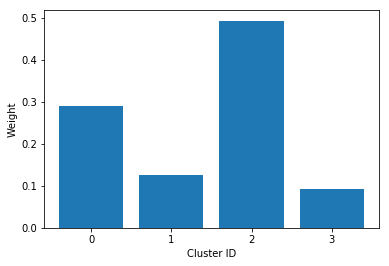

In [104]:
aa = [ 0.2898474,   0.12500354,  0.49343869,  0.09171037]
plt.bar(np.arange(4), aa)
plt.xticks(range(4))
plt.xlabel("Cluster ID")
plt.ylabel("Weight")
plt.show()

### a = 

# Cluster-based wmd distance and soft cosine distance


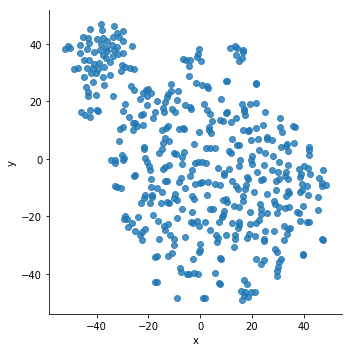

In [74]:
def test_vis(distance_matrix):
    X_embedded = TSNE(n_iter = 1000,
                      early_exaggeration = 10,
                      learning_rate = 900, 
                      method = "exact", 
                      metric = "precomputed").fit_transform(distance_matrix+0.000001)
    #X_embedded = decomposition.PCA(n_components=2).fit_transform(vecs)
    df = pd.DataFrame(X_embedded)
    #print(len(X_embedded))
    #df['label'] = sc.labels_
    df.columns = ['x', 'y']
    sns.lmplot(x="x", y="y",  data=df, fit_reg=False)
    plt.show()
test_vis(distance_matrix)

In [33]:
class PuncSplitTokenizer():
    """
        Map punctuations to space and then split, optional to remove predefined stopwords
    """
    def __init__(self, stopwords):
        __init__(self)
        self.stopwords = stopwords
    
    def __init__(self):
        self.translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
        self.stopwords = []
        
    def tokenize(self, text):
        tokens = text.translate(self.translator).lower().split()
        if self.stopwords:
            tokens = [t for t in tokens if t not in self.stopwords]
        return tokens

class TopicClusterGadget():
    """
        For vectorizing and computing document distance, based on word-topic-clusters in a document. 
        Implemented wmd_cosine, wmd_euclidean, and soft_cosine
    """
    def __init__(self, tokenizer, cls, distance_measure, word2vec, fixed_num_clusters):
        self.cls = cls
        self.tokenizer = tokenizer
        self.word2vec = word2vec
        self.distance_measure = distance_measure 
        self.fixed_num_clusters = fixed_num_clusters
        self.name = "{}+{}".format(cls, distance_measure)
        self.topics = []
        if distance_measure == "wmd_euclidean":
            self.get_distance = DistanceTool().wmd_distance_euclidean
        elif distance_measure == "wmd_cosine":
            self.get_distance = DistanceTool().wmd_distance_cosine
        elif self.distance_measure == "soft_cosine":
            self.get_distance = DistanceTool().softcosine_distance
        
    
    def tokenize(self, text):
        return self.tokenizer(text)
    
    def vectorize_all(self, train_X, test_X):
        train_vecs = [self.encode(t) for t in train_X]
        test_vecs = [self.encode(t) for t in test_X]
        max_len = np.max(np.concatenate(([len(a) for a in train_vecs], [len(a) for a in test_vecs])))
        train_vecs = np.asarray([np.pad(a, (0, max_len - len(a)), 'constant', constant_values=0) for a in train_vecs])
        test_vecs = np.asarray([np.pad(a, (0, max_len - len(a)), 'constant', constant_values=0) for a in test_vecs])
        return train_vecs, test_vecs
        
    def encode(self, text):
        text = self.tokenize(text)
        text = [t for t in text if t in self.word2vec]
        word_counter = Counter(text)
        word_counts = np.array(list(word_counter.values()))
        unique_text = np.array(list(word_counter.keys()))
        vecs = np.array([self.word2vec[w] for w in unique_text])
        num_clusters = math.floor(np.cbrt(len(unique_text))) if self.fixed_num_clusters <0 else self.fixed_num_clusters
                                
        if self.cls == "k-means": 
            model = KMeans(n_clusters = num_clusters, random_state=3425, precompute_distances = True)
            model.fit(vecs)
            distance_matrix = euclidean_distances(vecs)
            cluster_centers = model.cluster_centers_
            labels = model.labels_
        elif self.cls == "dsc":
            model = SpectralClustering(num_clusters, affinity='precomputed', random_state=3425,
                                    assign_labels = "discretize", n_init=2)
            similarity_matrix = cosine_similarity(vecs).clip(0,1) 
            model.fit(similarity_matrix) 
            distance_matrix = 1-similarity_matrix
            labels = model.labels_
        elif self.cls == "random":
            labels = np.array(random.choices(range(num_clusters), k = len(vecs)))
        non_empty_clusters = np.array(list(set(labels))) 
        
        indices = [np.where(labels == i) if i in non_empty_clusters 
                                                           else [] for i in range(num_clusters)]
        
        if self.cls in ["dsc", "random"]:
            cluster_centers = np.array([np.mean(vecs[indices[i]], axis = 0) for i in non_empty_clusters])
        
        #sizes = np.array([sum(word_counts[indices[i]]) for i in non_empty_clusters])
        weights = [(sum(importance_vecs(vecs[indices[i]]))/len(indices[i][0]))
                   *np.log(sum(word_counts[indices[i]])) for i in non_empty_clusters]
        weights = weights/sum(weights)
        return np.concatenate([[len(non_empty_clusters)], cluster_centers.flatten(), weights])
    
    def decode(self, a, b):
        num_clusters_a, num_clusters_b = int(a[0]), int(b[0])
        cut_a, cut_b = 1+300*num_clusters_a, 1+300*num_clusters_b
        topics1, topics2 = a[1:cut_a].reshape(-1,300), b[1:cut_b].reshape(-1,300)
        weights1, weights2 = a[cut_a:cut_a+num_clusters_a], b[cut_b:cut_b+num_clusters_b]
        allTopics = np.concatenate([topics1,topics2])
        d1 = np.concatenate([weights1,[0]*len(topics2)])
        d2 = np.concatenate([[0]*len(topics1),weights2])
        return d1, d2, allTopics

class DistanceTool():
    """
        Implemented wmd_cosine, wmd_euclidean, and soft_cosine
    """
    def decode(self, a, b):
        num_clusters_a, num_clusters_b = int(a[0]), int(b[0])
        cut_a, cut_b = 1+300*num_clusters_a, 1+300*num_clusters_b
        topics1, topics2 = a[1:cut_a].reshape(-1,300), b[1:cut_b].reshape(-1,300)
        weights1, weights2 = a[cut_a:cut_a+num_clusters_a], b[cut_b:cut_b+num_clusters_b]
        allTopics = np.concatenate([topics1,topics2])
        d1 = np.concatenate([weights1,[0]*len(topics2)])
        d2 = np.concatenate([[0]*len(topics1),weights2])
        return d1, d2, allTopics
    
    def softcosine_distance(self, vec1, vec2):
        d1, d2, allTopics = self.decode(vec1, vec2)
        similarity_matrix = cosine_similarity(allTopics).clip(0,1)
        base1 = d1.dot(similarity_matrix)
        result = base1.dot(d2)
        vec1 = base1.dot(d1)
        vec2 = d2.dot(similarity_matrix).dot(d2)
        result /= (np.sqrt(vec1)*np.sqrt(vec2))
        return 1-result
    
    def hausdorff_distance(self, vec1, vec2):
        num_clusters_a, num_clusters_b = int(a[0]), int(b[0])
        cut_a, cut_b = 1+300*num_clusters_a, 1+300*num_clusters_b
        topics1, topics2 = a[1:cut_a].reshape(-1,300), b[1:cut_b].reshape(-1,300)
        weights1, weights2 = a[cut_a:cut_a+num_clusters_a], b[cut_b:cut_b+num_clusters_b]
        
    def wmd_distance_euclidean(self, vec1, vec2):
        return self.wmd_distance(vec1, vec2, euclidean_distances)
    
    def wmd_distance_cosine(self, vec1, vec2):
        return self.wmd_distance(vec1, vec2, cosine_distances)
    
    def wmd_distance(self, vec1, vec2, distance_func):
        d1, d2, allTopics = self.decode(vec1, vec2)
        distance_matrix = distance_func(allTopics, allTopics)
        return emd(d1, d2, distance_matrix)

class WordAverageGadget():
    """
        Averaging word vectors method
    """
    def __init__(self, tokenizer, word2vec, weighting):
        self.word2vec = word2vec
        self.tokenizer = tokenizer
        self.cls = "average"
        self.distance_measure = "word_average"
        self.weighting = weighting
        
    def tokenize(self, text):
        return self.tokenizer(text)
    
    def vectorize_all(self, train_X, test_X):
        train_X = [self.encode(t) for t in train_X]
        test_X = [self.encode(t) for t in test_X]
        return train_X, test_X
    
    def encode(self, text):
        text = self.tokenize(text)
        if self.weighting:
            vecs = np.array([self.word2vec[word] for word in text if word in self.word2vec])
            importances = importance_vecs(vecs)
            weighted_vecs = [v*i for v, i in zip(vecs, importances)]
            return np.mean(weighted_vecs, axis = 0)
        else:
            vecs = [self.word2vec[w] for w in text if w in self.word2vec]
            return np.mean(vecs, axis=0)
    
    def decode(self):
        pass
        
class WordMoversDistanceGadget():
    """
        The original word mover's distance
    """
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.cls = "none"
        self.distance_measure = "wmd"
        
    def tokenize(self, text):
        pass
    
    def vectorize_all(self, train_X, test_X):
        vec_all = CountVectorizer(stop_words="english").fit(train_X + test_X)
        common = [word for word in vec_all.get_feature_names() if word in self.word2vec]
        self.word2vec_common = [self.word2vec[t] for t in common]
        vect = CountVectorizer(vocabulary=common, dtype=np.double)
        train_X = normalize(vect.fit_transform(train_X), norm = 'l1', copy = False)
        test_X = normalize(vect.transform(test_X), norm = 'l1', copy = False)
        return train_X, test_X
    
    def get_distance(self, vec1, vec2):
        indices = np.union1d(vec1.indices, vec2.indices)
        vecs = [self.word2vec_common[i] for i in indices]
        distance_matrix = euclidean_distances(vecs)
        d1 = vec1[indices]
        d2 = vec2[indices]
        return emd(d1, d2, distance_matrix)
    
    def get_distance_matrix(self, train_vecs, test_vecs):
        #dist = [[self.get_distance(i, j)] for i, j in test_vecs, train_vecs]
        #dist = np.array([self.get_distance(i, j) for u, v in test_vecs, train_vecs])
        #dist = dist.reshape(len(test_vecs), -1)
        #dist = Parallel(n_jobs=1)(
         #   delayed(self.get_distance)(test_sample, train_vecs)
          #  for test_sample in test_vecs)
        return dist
    def encode(self):
        pass
    
    def decode(self):
        pass



# Benchmarking

In [150]:

def mix_bbcnews(topics, mixed_groups, BBC):
    #bbcnews: 2225
    print("mixing bbc news")
    min_size = min([len(BBC[topic]) for topic in topics])
    size = int(min_size/len(mixed_groups))
    print("#total samples: {}".format(len(BBC.data)))
    print("#samples per label: {}".format(size))
    BBC_mixed = MyDataContainer({'data': [],
               'target': [],
               'topics': []})
    for i, topic_group in enumerate(mixed_groups):    
        for j in range(size):
            #document_samples = [BBCNews.data[random.choice(BBCNews[topic])] for topic in topic_group]
            document_samples = [BBC.data[BBC[topic][int(i*size+j)]] for topic in topic_group]
            new_document = " ".join(document_samples)
            BBC_mixed.data.append(new_document)
            BBC_mixed.target.append(i)
            BBC_mixed.topics.append(topic_group)
        print("label: {}, topics: {}".format(i, "+".join(topic_group)))
    print("{} records loaded".format(len(BBC_mixed.data)))
    return BBC_mixed

def mix_news20(topics, mixed_ids, mixed_group):
    print("mixing 20 news")
    news20_all = fetch_20newsgroups(categories=topics)
    data_labels = [fetch_20newsgroups(categories=[topic]).data for topic in topics]
    min_size = min([len(data) for data in data_labels])
    #lens = [len(data) for data.data in data_labels]
    size = int(min_size/len(mixed_groups))
    print("#total samples:{}".format(len(news20_all.data)))
    print("#samples per label:{}".format(size))
    
    news20_mixed = MyDataContainer({'data': [],
               'target': [],
               'topics': []})
    for i, topicid_group in enumerate(mixed_ids):
        #group_samples = [fetch_20newsgroups(categories=[topic]) for topic in topic_group]
        
        for j in range(size):
            document_samples = [data_labels[iid][i*size+j] for iid in topicid_group]
            new_document = " ".join(document_samples)
            news20_mixed.data.append(new_document)
            news20_mixed.target.append(i)
            news20_mixed.topics.append(mixed_group[i])
        print("label: {}, topics: {}".format(i, "+".join(mixed_group[i])))
    print("{} records loaded".format(len(news20_mixed.data)))
    return news20_all, news20_mixed
names_datasets = ["BBCSport_4", "BBCNews_4", "BBCNews_3", "BBCNews_2", "Newsgroup_4"]
topics_bbcsport = ["athletics", "cricket","football","rugby","tennis"]
topics = [topics_bbcsport[i] for i in [0,1,2,3,4]]
mixed_ids = [[0,1,2,3],
             [0,1,2,4],
             [0,1,3,4],
             [0,2,3,4],
             [1,2,3,4]]
mixed_groups = [ [topics[id] for id in ids] for ids in mixed_ids ]
BBCSport_mixed1 = mix_bbcnews(topics, mixed_groups, BBCSport)

topics_bbcnews = ["business", "entertainment", "politics", "sport", "tech"]    
topics = [topics_bbcnews[i] for i in [0,1,2,3,4]]
mixed_ids = [[0,1,2,3],
             [0,1,2,4],
             [0,1,3,4],
             [0,2,3,4],
             [1,2,3,4]]
mixed_groups = [ [topics[id] for id in ids] for ids in mixed_ids ]
BBCNews_mixed1 = mix_bbcnews(topics, mixed_groups, BBCNews)

topics = [topics_bbcnews[i] for i in [1,2,3,4]]
mixed_ids = [[0,1,2],
             [0,1,3],
             [0,2,3],
             [1,2,3]]

mixed_groups = [ [topics[id] for id in ids] for ids in mixed_ids ]

BBCNews_mixed2 = mix_bbcnews(topics, mixed_groups, BBCNews)

topics = [topics_bbcnews[i] for i in [0,1,4]]
mixed_ids = [[0,1],
             [0,2],
             [1,2]]

mixed_groups = [ [topics[id] for id in ids] for ids in mixed_ids ]

BBCNews_mixed3 = mix_bbcnews(topics, mixed_groups, BBCNews)

topics_news20 = ['comp.sys.ibm.pc.hardware', 
              'rec.autos',
              'sci.space',
              'rec.sport.baseball',
              'sci.crypt']
              #'talk.politics.guns']

topics = topics_news20

mixed_ids = [[0,1,2,3],
             [0,1,2,4],
             [0,1,3,4],
             [0,2,3,4],
             [1,2,3,4]]

mixed_groups = [ [topics[id] for id in ids] for ids in mixed_ids ]

news20_all, news20_mixed1 = mix_news20(topics, mixed_ids, mixed_groups)

topics = topics_news20

mixed_ids = [[1,2,3],
             [1,2,4],
             [1,3,4],
             [2,3,4]]

mixed_groups = [ [topics[id] for id in ids] for ids in mixed_ids ]

news20_all, news20_mixed2 = mix_news20(topics, mixed_ids, mixed_groups)

mixing bbc news
#total samples: 737
#samples per label: 20
label: 0, topics: athletics+cricket+football+rugby
label: 1, topics: athletics+cricket+football+tennis
label: 2, topics: athletics+cricket+rugby+tennis
label: 3, topics: athletics+football+rugby+tennis
label: 4, topics: cricket+football+rugby+tennis
100 records loaded
mixing bbc news
#total samples: 2225
#samples per label: 77
label: 0, topics: business+entertainment+politics+sport
label: 1, topics: business+entertainment+politics+tech
label: 2, topics: business+entertainment+sport+tech
label: 3, topics: business+politics+sport+tech
label: 4, topics: entertainment+politics+sport+tech
385 records loaded
mixing bbc news
#total samples: 2225
#samples per label: 96
label: 0, topics: entertainment+politics+sport
label: 1, topics: entertainment+politics+tech
label: 2, topics: entertainment+sport+tech
label: 3, topics: politics+sport+tech
384 records loaded
mixing bbc news
#total samples: 2225
#samples per label: 128
label: 0, topics:

In [843]:

def create_subset(data, k):
    subset = MyDataContainer({'data': [],
               'target': [],
               'topics': []})
    for i in range(len(set(data.target))):
        targets = np.array(data.target)
        ids = np.where(targets == i)[0]
        sample_ids = random.choices(ids, k = k)
        print(sample_ids)
        sample_docs = [data.data[j] for j in sample_ids]
        subset.data.extend(sample_docs)
        subset.target.extend([i]*k)
        
        subset.topics.extend([data.topics[sample_ids[0]]]*k)
    return subset
BBCNews_mixed_sample = create_subset(BBCNews_mixed1, 10)
print(BBCNews_mixed1.topics[0])
print(len(BBCNews_mixed_sample.data))

[3, 31, 40, 61, 51, 87, 53, 48, 6, 17]
[100, 179, 185, 122, 175, 159, 179, 184, 108, 126]
[222, 212, 194, 255, 257, 201, 206, 229, 278, 235]
[330, 360, 366, 364, 328, 297, 332, 365, 374, 292]
['business', 'entertainment', 'politics']
40


In [66]:
word_dic = word2vec
datasets = [news20_mixed2]

stopwords_tokenizer = CountVectorizer(stop_words = "english").build_analyzer()
nostopwords_tokenizer = CountVectorizer().build_analyzer()
remove_stopwords = True
if remove_stopwords:
    tokenizerx = nostopwords_tokenizer
else:
    tokenizerx = nostopwords_tokenizer

#models = [WordMoversDistanceGadget(word_dic)]

mystopwords = "english" if remove_stopwords else None

bowVectorizer = make_pipeline(CountVectorizer(stop_words = mystopwords), 
                              Normalizer(norm = 'l1', copy = False)) 

tfidfVectorizer = make_pipeline(TfidfVectorizer(stop_words = mystopwords,use_idf = True),
                               Normalizer(norm = 'l1', copy = False))

BLmodels = [[bowVectorizer], [tfidfVectorizer]]

LDAmodels = [[make_pipeline(CountVectorizer(stop_words = mystopwords)
                              ,lda.LDA(n_topics=i, n_iter=100)) for i in range(10,40,2)]]

LSImodels = [[make_pipeline(CountVectorizer(stop_words = mystopwords), 
                                 Normalizer(norm = 'l1', copy = False), 
                                 TruncatedSVD(i)) for i in range(50,400,30)]]
WCDmodels = [WordAverageGadget(tokenizerx, word_dic, False),
            WordAverageGadget(tokenizerx, word_dic, True)]
n_k = 10
KMmodels = [[TopicClusterGadget(tokenizerx, "k-means", "wmd_euclidean", word_dic,n_k),
          #TopicClusterGadget(tokenizerx, "k-means", "wmd_cosine", word_dic,n_k),
          TopicClusterGadget(tokenizerx, "k-means", "soft_cosine", word_dic,n_k)]]

DSCmodels = [[TopicClusterGadget(tokenizerx, "dsc", "wmd_euclidean", word_dic,n_k),
              #TopicClusterGadget(tokenizerx, "dsc", "wmd_cosine", word_dic,n_k),
              TopicClusterGadget(tokenizerx, "dsc", "soft_cosine", word_dic,n_k)]]
classicals = ["BOW", "TF-IDF", "LSI", "LDA"]
WCDs = ["WCD", "WCD_I"]
KMs = ["kmeans_wmd_euclidean", "kmeans_soft_cosine"]
DSCs = ["dsc_wmd", "dsc_soft_cosine"]

k_values = range(10,35,5)
results_per_dataset=[]

for ds in datasets:
    accuracies = []
    train_X, test_X, train_y, test_y = train_test_split(ds.data, ds.target, test_size=0.4, 
                                                        shuffle = True, stratify = ds.target, random_state=42)
    
    cont_X, valid_X, cont_y, valid_y = train_test_split(train_X, train_y, test_size = 0.3, 
                                                        shuffle = True, random_state = 42, stratify = train_y)
    print("Training size:{}\n Test size:{}".format(len(train_X), len(test_X)))
    print("#Label: {}".format(len(set(train_y))))
    
    #print("Evaluating classical models...")
    for k in k_values: 
        k_accuracies = []
        
        print("fitting KNN for k = {}".format(k))
        for i, models in enumerate(BLmodels+LSImodels+LDAmodels): 
            print("fitting {}".format(classicals[i]))
            model_classification_reports = []
            max_accuracy = 0
            
            best_model = None
            max_accuracy = 0
            for model in models:
                model.fit(list(train_X)+list(test_X))
                cont_vecs = model.transform(cont_X)
                valid_vecs = model.transform(valid_X)
                nbrs = KNeighborsClassifier(algorithm='brute', metric = "cosine", n_neighbors = k)
                nbrs.fit(cont_vecs, cont_y)
                prediction = nbrs.predict(valid_vecs)
                acc = accuracy_score(prediction, valid_y)
                if max_accuracy < acc:
                    print("find better")
                    best_model = model
                    best_tree = nbrs
                max_accuracy = acc
                #model_classification_reports.append(classification_report(test_y, prediction))
                #classification_reports.append(model_classification_reports)
            best_model.fit(list(train_X)+list(test_X))
            train_vecs = best_model.transform(train_X)
            test_vecs = best_model.transform(test_X)
            best_tree.fit(train_vecs, train_y)
            prediction = best_tree.predict(test_vecs)
            acc = accuracy_score(prediction, test_y)
            print("accuracy: {}".format(acc))
            k_accuracies.append(acc)   
        
        for model in WCDmodels:
            for metric in ["cosine"]:
                print("fitting WCD {}".format(metric))
                train_vecs, test_vecs = model.vectorize_all(train_X, test_X)
                nbrs = KNeighborsClassifier(algorithm='brute', metric = metric, n_neighbors = k)
                nbrs.fit(train_vecs, train_y)
                print("predicting")
                prediction = nbrs.predict(test_vecs)
                acc = accuracy_score(prediction, test_y)
                print("accuracy: {}".format(acc))
                k_accuracies.append(acc)

        for names, models in zip([DSCs],DSCmodels):
            start = time.time()
            print("fitting {}".format(models[0].cls))
            train_vecs, test_vecs = models[0].vectorize_all(train_X, test_X)
            print("{}s for vectorization".format(time.time() - start))
            for i, model in enumerate(models):
                print("predicting {}".format(names[i]))
                start = time.time()
                nbrs = KNeighborsClassifier(algorithm='ball_tree', n_neighbors = k,
                                    metric=lambda a,b: model.get_distance(a, b))
                nbrs.fit(train_vecs, train_y)
                prediction = nbrs.predict(test_vecs)
                acc = accuracy_score(prediction, test_y)
                print("{}s for predicting".format(time.time()-start))
                print("accuracy: {}".format(acc))
                k_accuracies.append(acc)
        accuracies.append(k_accuracies)
    results_per_dataset.append(accuracies)
                

Training size:352
 Test size:236
#Label: 4
fitting KNN for k = 10
fitting BOW
find better
accuracy: 0.4449152542372881
fitting TF-IDF
find better
accuracy: 0.5042372881355932
fitting LSI
find better
find better
find better
find better
find better
accuracy: 0.4576271186440678
fitting LDA


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 10
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3492369
INFO:lda:<10> log likelihood: -2871041
INFO:lda:<20> log likelihood: -2778002
INFO:lda:<30> log likelihood: -2749333
INFO:lda:<40> log likelihood: -2731725
INFO:lda:<50> log likelihood: -2721088
INFO:lda:<60> log likelihood: -2713692
INFO:lda:<70> log likelihood: -2706179
INFO:lda:<80> log likelihood: -2700559
INFO:lda:<90> log likelihood: -2693792
INFO:lda:<99> log likelihood: -2689662


find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 12
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3563225
INFO:lda:<10> log likelihood: -2890573
INFO:lda:<20> log likelihood: -2799621
INFO:lda:<30> log likelihood: -2767430
INFO:lda:<40> log likelihood: -2750508
INFO:lda:<50> log likelihood: -2739101
INFO:lda:<60> log likelihood: -2732666
INFO:lda:<70> log likelihood: -2725702
INFO:lda:<80> log likelihood: -2720554
INFO:lda:<90> log likelihood: -2715612
INFO:lda:<99> log likelihood: -2711544


find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 14
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3623994
INFO:lda:<10> log likelihood: -2892036
INFO:lda:<20> log likelihood: -2797027
INFO:lda:<30> log likelihood: -2763524
INFO:lda:<40> log likelihood: -2747019
INFO:lda:<50> log likelihood: -2734442
INFO:lda:<60> log likelihood: -2725711
INFO:lda:<70> log likelihood: -2716845
INFO:lda:<80> log likelihood: -2713156
INFO:lda:<90> log likelihood: -2707315
INFO:lda:<99> log likelihood: -2701381
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 16
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3676449
INFO:lda:<10> log likelihood: -2895261
INFO:lda:<20> log likelihood: -2802006
INFO:lda:<30> log likelihood: -2768638
INFO:lda:<40> log likelihood: -2749118
INFO:lda:<50> log likelihood: -2735113
INFO:lda:<60> log likelihood: -2724451
INFO:lda:<70> log likelihood: -2717738
INFO:lda:<80> log l

find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 26
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3869853
INFO:lda:<10> log likelihood: -2912803
INFO:lda:<20> log likelihood: -2821647
INFO:lda:<30> log likelihood: -2784476
INFO:lda:<40> log likelihood: -2763898
INFO:lda:<50> log likelihood: -2748383
INFO:lda:<60> log likelihood: -2735353
INFO:lda:<70> log likelihood: -2727620
INFO:lda:<80> log likelihood: -2719181
INFO:lda:<90> log likelihood: -2713006
INFO:lda:<99> log likelihood: -2707773


find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 28
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3900452
INFO:lda:<10> log likelihood: -2920555
INFO:lda:<20> log likelihood: -2825021
INFO:lda:<30> log likelihood: -2787403
INFO:lda:<40> log likelihood: -2765470
INFO:lda:<50> log likelihood: -2750342
INFO:lda:<60> log likelihood: -2735280
INFO:lda:<70> log likelihood: -2724917
INFO:lda:<80> log likelihood: -2717398
INFO:lda:<90> log likelihood: -2710041
INFO:lda:<99> log likelihood: -2704193
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 30
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3928669
INFO:lda:<10> log likelihood: -2922424
INFO:lda:<20> log likelihood: -2825097
INFO:lda:<30> log likelihood: -2785570
INFO:lda:<40> log likelihood: -2765013
INFO:lda:<50> log likelihood: -2748502
INFO:lda:<60> log likelihood: -2738219
INFO:lda:<70> log likelihood: -2727963
INFO:lda:<80> log l

find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 38
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -4022435
INFO:lda:<10> log likelihood: -2934995
INFO:lda:<20> log likelihood: -2832965
INFO:lda:<30> log likelihood: -2792928
INFO:lda:<40> log likelihood: -2768458
INFO:lda:<50> log likelihood: -2750297
INFO:lda:<60> log likelihood: -2736752
INFO:lda:<70> log likelihood: -2725249
INFO:lda:<80> log likelihood: -2717365
INFO:lda:<90> log likelihood: -2709941
INFO:lda:<99> log likelihood: -2704113
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 36
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -4000803
INFO:lda:<10> log likelihood: -2928367
INFO:lda:<20> log likelihood: -2828236
INFO:lda:<30> log likelihood: -2787718
INFO:lda:<40> log likelihood: -2765191
INFO:lda:<50> log likelihood: -2746511
INFO:lda:<60> log likelihood: -2734722
INFO:lda:<70> log likelihood: -2726042
INFO:lda:<80> log l

accuracy: 0.3474576271186441
fitting WCD cosine
predicting
accuracy: 0.5211864406779662
fitting WCD cosine
predicting
accuracy: 0.5254237288135594
fitting dsc
21.556610822677612s for vectorization
predicting dsc_wmd
45.93428182601929s for predicting
accuracy: 0.4406779661016949
predicting dsc_soft_cosine
14.467682123184204s for predicting
accuracy: 0.635593220338983
fitting KNN for k = 15
fitting BOW
find better
accuracy: 0.5
fitting TF-IDF
find better
accuracy: 0.5211864406779662
fitting LSI
find better
find better
find better
find better
accuracy: 0.461864406779661
fitting LDA


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 10
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3492369
INFO:lda:<10> log likelihood: -2881789
INFO:lda:<20> log likelihood: -2798451
INFO:lda:<30> log likelihood: -2762070
INFO:lda:<40> log likelihood: -2742907
INFO:lda:<50> log likelihood: -2731845
INFO:lda:<60> log likelihood: -2722592
INFO:lda:<70> log likelihood: -2715715
INFO:lda:<80> log likelihood: -2709786
INFO:lda:<90> log likelihood: -2705316
INFO:lda:<99> log likelihood: -2701923


find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 12
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3563225
INFO:lda:<10> log likelihood: -2881356
INFO:lda:<20> log likelihood: -2795298
INFO:lda:<30> log likelihood: -2763855
INFO:lda:<40> log likelihood: -2743539
INFO:lda:<50> log likelihood: -2733346
INFO:lda:<60> log likelihood: -2722516
INFO:lda:<70> log likelihood: -2713875
INFO:lda:<80> log likelihood: -2708981
INFO:lda:<90> log likelihood: -2703723
INFO:lda:<99> log likelihood: -2698887


find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 14
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3623994
INFO:lda:<10> log likelihood: -2900737
INFO:lda:<20> log likelihood: -2798670
INFO:lda:<30> log likelihood: -2760307
INFO:lda:<40> log likelihood: -2742261
INFO:lda:<50> log likelihood: -2729761
INFO:lda:<60> log likelihood: -2718340
INFO:lda:<70> log likelihood: -2709752
INFO:lda:<80> log likelihood: -2702603
INFO:lda:<90> log likelihood: -2695020
INFO:lda:<99> log likelihood: -2690799
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 16
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3676449
INFO:lda:<10> log likelihood: -2896020
INFO:lda:<20> log likelihood: -2803272
INFO:lda:<30> log likelihood: -2771752
INFO:lda:<40> log likelihood: -2751503
INFO:lda:<50> log likelihood: -2739163
INFO:lda:<60> log likelihood: -2729427
INFO:lda:<70> log likelihood: -2721443
INFO:lda:<80> log l

find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 20
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3765191
INFO:lda:<10> log likelihood: -2915883
INFO:lda:<20> log likelihood: -2816731
INFO:lda:<30> log likelihood: -2781188
INFO:lda:<40> log likelihood: -2760867
INFO:lda:<50> log likelihood: -2747404
INFO:lda:<60> log likelihood: -2735937
INFO:lda:<70> log likelihood: -2726475
INFO:lda:<80> log likelihood: -2718566
INFO:lda:<90> log likelihood: -2709905
INFO:lda:<99> log likelihood: -2703289


find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 22
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3803021
INFO:lda:<10> log likelihood: -2908130
INFO:lda:<20> log likelihood: -2817610
INFO:lda:<30> log likelihood: -2782831
INFO:lda:<40> log likelihood: -2762998
INFO:lda:<50> log likelihood: -2749344
INFO:lda:<60> log likelihood: -2739122
INFO:lda:<70> log likelihood: -2731144
INFO:lda:<80> log likelihood: -2724236
INFO:lda:<90> log likelihood: -2718677
INFO:lda:<99> log likelihood: -2712184


find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 24
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3837514
INFO:lda:<10> log likelihood: -2913423
INFO:lda:<20> log likelihood: -2818175
INFO:lda:<30> log likelihood: -2781793
INFO:lda:<40> log likelihood: -2761506
INFO:lda:<50> log likelihood: -2748265
INFO:lda:<60> log likelihood: -2736837
INFO:lda:<70> log likelihood: -2726870
INFO:lda:<80> log likelihood: -2719538
INFO:lda:<90> log likelihood: -2713153
INFO:lda:<99> log likelihood: -2706047
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 26
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3869853
INFO:lda:<10> log likelihood: -2911439
INFO:lda:<20> log likelihood: -2815999
INFO:lda:<30> log likelihood: -2781229
INFO:lda:<40> log likelihood: -2760594
INFO:lda:<50> log likelihood: -2744871
INFO:lda:<60> log likelihood: -2732898
INFO:lda:<70> log likelihood: -2722484
INFO:lda:<80> log l

find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 32
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3952780
INFO:lda:<10> log likelihood: -2929025
INFO:lda:<20> log likelihood: -2828044
INFO:lda:<30> log likelihood: -2789822
INFO:lda:<40> log likelihood: -2765902
INFO:lda:<50> log likelihood: -2747581
INFO:lda:<60> log likelihood: -2735456
INFO:lda:<70> log likelihood: -2724361
INFO:lda:<80> log likelihood: -2715537
INFO:lda:<90> log likelihood: -2707500
INFO:lda:<99> log likelihood: -2698962
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 34
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3978412
INFO:lda:<10> log likelihood: -2927828
INFO:lda:<20> log likelihood: -2831806
INFO:lda:<30> log likelihood: -2790964
INFO:lda:<40> log likelihood: -2767177
INFO:lda:<50> log likelihood: -2750289
INFO:lda:<60> log likelihood: -2736837
INFO:lda:<70> log likelihood: -2726827
INFO:lda:<80> log l

find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 38
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -4022435
INFO:lda:<10> log likelihood: -2930593
INFO:lda:<20> log likelihood: -2835388
INFO:lda:<30> log likelihood: -2793968
INFO:lda:<40> log likelihood: -2770061
INFO:lda:<50> log likelihood: -2751625
INFO:lda:<60> log likelihood: -2737743
INFO:lda:<70> log likelihood: -2728656
INFO:lda:<80> log likelihood: -2721299
INFO:lda:<90> log likelihood: -2713793
INFO:lda:<99> log likelihood: -2708406


accuracy: 0.4364406779661017
fitting WCD cosine
predicting
accuracy: 0.5720338983050848
fitting WCD cosine
predicting
accuracy: 0.5423728813559322
fitting dsc
22.822057962417603s for vectorization
predicting dsc_wmd
46.339855909347534s for predicting
accuracy: 0.5169491525423728
predicting dsc_soft_cosine
14.664543151855469s for predicting
accuracy: 0.635593220338983
fitting KNN for k = 20
fitting BOW
find better
accuracy: 0.4449152542372881
fitting TF-IDF
find better
accuracy: 0.5084745762711864
fitting LSI
find better
find better
find better
find better
find better
accuracy: 0.4915254237288136
fitting LDA


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 10
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3492369
INFO:lda:<10> log likelihood: -2874118
INFO:lda:<20> log likelihood: -2784384
INFO:lda:<30> log likelihood: -2751169
INFO:lda:<40> log likelihood: -2734081
INFO:lda:<50> log likelihood: -2727462
INFO:lda:<60> log likelihood: -2719618
INFO:lda:<70> log likelihood: -2714818
INFO:lda:<80> log likelihood: -2709467
INFO:lda:<90> log likelihood: -2705410
INFO:lda:<99> log likelihood: -2702195


find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 12
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3563225
INFO:lda:<10> log likelihood: -2883661
INFO:lda:<20> log likelihood: -2794816
INFO:lda:<30> log likelihood: -2765095
INFO:lda:<40> log likelihood: -2748090
INFO:lda:<50> log likelihood: -2737773
INFO:lda:<60> log likelihood: -2729342
INFO:lda:<70> log likelihood: -2721612
INFO:lda:<80> log likelihood: -2714837
INFO:lda:<90> log likelihood: -2712500
INFO:lda:<99> log likelihood: -2707503
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 14
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3623994
INFO:lda:<10> log likelihood: -2886767
INFO:lda:<20> log likelihood: -2794583
INFO:lda:<30> log likelihood: -2759426
INFO:lda:<40> log likelihood: -2739114
INFO:lda:<50> log likelihood: -2724936
INFO:lda:<60> log likelihood: -2713533
INFO:lda:<70> log likelihood: -2704300
INFO:lda:<80> log l

find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 16
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3676449
INFO:lda:<10> log likelihood: -2887510
INFO:lda:<20> log likelihood: -2798991
INFO:lda:<30> log likelihood: -2766966
INFO:lda:<40> log likelihood: -2747630
INFO:lda:<50> log likelihood: -2735688
INFO:lda:<60> log likelihood: -2726688
INFO:lda:<70> log likelihood: -2717097
INFO:lda:<80> log likelihood: -2709769
INFO:lda:<90> log likelihood: -2703494
INFO:lda:<99> log likelihood: -2698514
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 18
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3723569
INFO:lda:<10> log likelihood: -2898804
INFO:lda:<20> log likelihood: -2805766
INFO:lda:<30> log likelihood: -2772060
INFO:lda:<40> log likelihood: -2754003
INFO:lda:<50> log likelihood: -2741606
INFO:lda:<60> log likelihood: -2731729
INFO:lda:<70> log likelihood: -2725406
INFO:lda:<80> log l

find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 22
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3803021
INFO:lda:<10> log likelihood: -2913212
INFO:lda:<20> log likelihood: -2816754
INFO:lda:<30> log likelihood: -2779328
INFO:lda:<40> log likelihood: -2756704
INFO:lda:<50> log likelihood: -2742121
INFO:lda:<60> log likelihood: -2732030
INFO:lda:<70> log likelihood: -2723238
INFO:lda:<80> log likelihood: -2714501
INFO:lda:<90> log likelihood: -2708225
INFO:lda:<99> log likelihood: -2702460
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 24
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3837514
INFO:lda:<10> log likelihood: -2919286
INFO:lda:<20> log likelihood: -2821534
INFO:lda:<30> log likelihood: -2783956
INFO:lda:<40> log likelihood: -2762821
INFO:lda:<50> log likelihood: -2745852
INFO:lda:<60> log likelihood: -2734872
INFO:lda:<70> log likelihood: -2724873
INFO:lda:<80> log l

find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 28
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3900452
INFO:lda:<10> log likelihood: -2927322
INFO:lda:<20> log likelihood: -2830281
INFO:lda:<30> log likelihood: -2790623
INFO:lda:<40> log likelihood: -2769092
INFO:lda:<50> log likelihood: -2753500
INFO:lda:<60> log likelihood: -2740895
INFO:lda:<70> log likelihood: -2733718
INFO:lda:<80> log likelihood: -2727745
INFO:lda:<90> log likelihood: -2719249
INFO:lda:<99> log likelihood: -2715154
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 30
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3928669
INFO:lda:<10> log likelihood: -2925443
INFO:lda:<20> log likelihood: -2823205
INFO:lda:<30> log likelihood: -2785301
INFO:lda:<40> log likelihood: -2763719
INFO:lda:<50> log likelihood: -2745836
INFO:lda:<60> log likelihood: -2735213
INFO:lda:<70> log likelihood: -2724567
INFO:lda:<80> log l

find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 32
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3952780
INFO:lda:<10> log likelihood: -2922468
INFO:lda:<20> log likelihood: -2825704
INFO:lda:<30> log likelihood: -2787736
INFO:lda:<40> log likelihood: -2762629
INFO:lda:<50> log likelihood: -2748571
INFO:lda:<60> log likelihood: -2733014
INFO:lda:<70> log likelihood: -2723045
INFO:lda:<80> log likelihood: -2715265
INFO:lda:<90> log likelihood: -2707618
INFO:lda:<99> log likelihood: -2702267


find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 34
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3978412
INFO:lda:<10> log likelihood: -2925332
INFO:lda:<20> log likelihood: -2825843
INFO:lda:<30> log likelihood: -2787164
INFO:lda:<40> log likelihood: -2764112
INFO:lda:<50> log likelihood: -2747661
INFO:lda:<60> log likelihood: -2735770
INFO:lda:<70> log likelihood: -2726311
INFO:lda:<80> log likelihood: -2719477
INFO:lda:<90> log likelihood: -2712708
INFO:lda:<99> log likelihood: -2706937
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 36
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -4000803
INFO:lda:<10> log likelihood: -2929124
INFO:lda:<20> log likelihood: -2832597
INFO:lda:<30> log likelihood: -2789281
INFO:lda:<40> log likelihood: -2766706
INFO:lda:<50> log likelihood: -2751169
INFO:lda:<60> log likelihood: -2738620
INFO:lda:<70> log likelihood: -2728010
INFO:lda:<80> log l

find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 38
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -4022435
INFO:lda:<10> log likelihood: -2927723
INFO:lda:<20> log likelihood: -2826302
INFO:lda:<30> log likelihood: -2787138
INFO:lda:<40> log likelihood: -2762110
INFO:lda:<50> log likelihood: -2743117
INFO:lda:<60> log likelihood: -2730010
INFO:lda:<70> log likelihood: -2719006
INFO:lda:<80> log likelihood: -2706922
INFO:lda:<90> log likelihood: -2697281
INFO:lda:<99> log likelihood: -2688232


accuracy: 0.4067796610169492
fitting WCD cosine
predicting
accuracy: 0.559322033898305
fitting WCD cosine
predicting
accuracy: 0.5466101694915254
fitting dsc
23.4897301197052s for vectorization
predicting dsc_wmd
45.93318295478821s for predicting
accuracy: 0.5211864406779662
predicting dsc_soft_cosine
14.325629949569702s for predicting
accuracy: 0.6186440677966102
fitting KNN for k = 25
fitting BOW
find better
accuracy: 0.5
fitting TF-IDF
find better
accuracy: 0.5169491525423728
fitting LSI
find better
find better
find better
find better
find better
find better
accuracy: 0.5084745762711864
fitting LDA


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 10
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3492369
INFO:lda:<10> log likelihood: -2872969
INFO:lda:<20> log likelihood: -2784907
INFO:lda:<30> log likelihood: -2753420
INFO:lda:<40> log likelihood: -2735935
INFO:lda:<50> log likelihood: -2722994
INFO:lda:<60> log likelihood: -2715454
INFO:lda:<70> log likelihood: -2710420
INFO:lda:<80> log likelihood: -2705412
INFO:lda:<90> log likelihood: -2702215
INFO:lda:<99> log likelihood: -2699165


find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 12
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3563225
INFO:lda:<10> log likelihood: -2890518
INFO:lda:<20> log likelihood: -2799576
INFO:lda:<30> log likelihood: -2766231
INFO:lda:<40> log likelihood: -2748242
INFO:lda:<50> log likelihood: -2735296
INFO:lda:<60> log likelihood: -2727468
INFO:lda:<70> log likelihood: -2721531
INFO:lda:<80> log likelihood: -2715979
INFO:lda:<90> log likelihood: -2711860
INFO:lda:<99> log likelihood: -2708965


find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 14
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3623994
INFO:lda:<10> log likelihood: -2892279
INFO:lda:<20> log likelihood: -2797129
INFO:lda:<30> log likelihood: -2762406
INFO:lda:<40> log likelihood: -2746765
INFO:lda:<50> log likelihood: -2735125
INFO:lda:<60> log likelihood: -2725587
INFO:lda:<70> log likelihood: -2718826
INFO:lda:<80> log likelihood: -2712214
INFO:lda:<90> log likelihood: -2707652
INFO:lda:<99> log likelihood: -2704113


find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 16
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3676449
INFO:lda:<10> log likelihood: -2895545
INFO:lda:<20> log likelihood: -2805172
INFO:lda:<30> log likelihood: -2774542
INFO:lda:<40> log likelihood: -2755905
INFO:lda:<50> log likelihood: -2739667
INFO:lda:<60> log likelihood: -2728032
INFO:lda:<70> log likelihood: -2719018
INFO:lda:<80> log likelihood: -2710826
INFO:lda:<90> log likelihood: -2701828
INFO:lda:<99> log likelihood: -2693104
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 18
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3723569
INFO:lda:<10> log likelihood: -2910301
INFO:lda:<20> log likelihood: -2817203
INFO:lda:<30> log likelihood: -2782146
INFO:lda:<40> log likelihood: -2760819
INFO:lda:<50> log likelihood: -2747916
INFO:lda:<60> log likelihood: -2737795
INFO:lda:<70> log likelihood: -2729057
INFO:lda:<80> log l

find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 30
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3928669
INFO:lda:<10> log likelihood: -2927980
INFO:lda:<20> log likelihood: -2828869
INFO:lda:<30> log likelihood: -2790493
INFO:lda:<40> log likelihood: -2767267
INFO:lda:<50> log likelihood: -2750695
INFO:lda:<60> log likelihood: -2738460
INFO:lda:<70> log likelihood: -2728666
INFO:lda:<80> log likelihood: -2720608
INFO:lda:<90> log likelihood: -2711556
INFO:lda:<99> log likelihood: -2705329


find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 32
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3952780
INFO:lda:<10> log likelihood: -2927390
INFO:lda:<20> log likelihood: -2830151
INFO:lda:<30> log likelihood: -2792384
INFO:lda:<40> log likelihood: -2770005
INFO:lda:<50> log likelihood: -2752761
INFO:lda:<60> log likelihood: -2740928
INFO:lda:<70> log likelihood: -2732810
INFO:lda:<80> log likelihood: -2725055
INFO:lda:<90> log likelihood: -2717815
INFO:lda:<99> log likelihood: -2712370
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 34
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3978412
INFO:lda:<10> log likelihood: -2923661
INFO:lda:<20> log likelihood: -2823869
INFO:lda:<30> log likelihood: -2787666
INFO:lda:<40> log likelihood: -2763405
INFO:lda:<50> log likelihood: -2747815
INFO:lda:<60> log likelihood: -2733805
INFO:lda:<70> log likelihood: -2724031
INFO:lda:<80> log l

find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 36
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -4000803
INFO:lda:<10> log likelihood: -2929297
INFO:lda:<20> log likelihood: -2830870
INFO:lda:<30> log likelihood: -2791269
INFO:lda:<40> log likelihood: -2766047
INFO:lda:<50> log likelihood: -2749301
INFO:lda:<60> log likelihood: -2735938
INFO:lda:<70> log likelihood: -2727682
INFO:lda:<80> log likelihood: -2718750
INFO:lda:<90> log likelihood: -2711843
INFO:lda:<99> log likelihood: -2706148


find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 38
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -4022435
INFO:lda:<10> log likelihood: -2932634
INFO:lda:<20> log likelihood: -2834108
INFO:lda:<30> log likelihood: -2793582
INFO:lda:<40> log likelihood: -2769193
INFO:lda:<50> log likelihood: -2752621
INFO:lda:<60> log likelihood: -2738377
INFO:lda:<70> log likelihood: -2727611
INFO:lda:<80> log likelihood: -2720007
INFO:lda:<90> log likelihood: -2712322
INFO:lda:<99> log likelihood: -2705093
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 36
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -4000803
INFO:lda:<10> log likelihood: -2930995
INFO:lda:<20> log likelihood: -2832174
INFO:lda:<30> log likelihood: -2791429
INFO:lda:<40> log likelihood: -2766908
INFO:lda:<50> log likelihood: -2750418
INFO:lda:<60> log likelihood: -2738315
INFO:lda:<70> log likelihood: -2728552
INFO:lda:<80> log l

accuracy: 0.3601694915254237
fitting WCD cosine
predicting
accuracy: 0.5508474576271186
fitting WCD cosine
predicting
accuracy: 0.538135593220339
fitting dsc
21.247375011444092s for vectorization
predicting dsc_wmd
46.07271909713745s for predicting
accuracy: 0.5254237288135594
predicting dsc_soft_cosine
14.748533010482788s for predicting
accuracy: 0.597457627118644
fitting KNN for k = 30
fitting BOW
find better
accuracy: 0.5084745762711864
fitting TF-IDF
find better
accuracy: 0.5169491525423728
fitting LSI
find better
find better
find better
find better
find better
accuracy: 0.5254237288135594
fitting LDA


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 10
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3492369
INFO:lda:<10> log likelihood: -2870777
INFO:lda:<20> log likelihood: -2776414
INFO:lda:<30> log likelihood: -2746888
INFO:lda:<40> log likelihood: -2732516
INFO:lda:<50> log likelihood: -2721545
INFO:lda:<60> log likelihood: -2714314
INFO:lda:<70> log likelihood: -2706916
INFO:lda:<80> log likelihood: -2702601
INFO:lda:<90> log likelihood: -2698272
INFO:lda:<99> log likelihood: -2695147


find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 12
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3563225
INFO:lda:<10> log likelihood: -2880912
INFO:lda:<20> log likelihood: -2790110
INFO:lda:<30> log likelihood: -2760577
INFO:lda:<40> log likelihood: -2743931
INFO:lda:<50> log likelihood: -2734972
INFO:lda:<60> log likelihood: -2726380
INFO:lda:<70> log likelihood: -2720164
INFO:lda:<80> log likelihood: -2715367
INFO:lda:<90> log likelihood: -2709715
INFO:lda:<99> log likelihood: -2707065
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 14
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3623994
INFO:lda:<10> log likelihood: -2884536
INFO:lda:<20> log likelihood: -2791393
INFO:lda:<30> log likelihood: -2763745
INFO:lda:<40> log likelihood: -2747179
INFO:lda:<50> log likelihood: -2734701
INFO:lda:<60> log likelihood: -2726309
INFO:lda:<70> log likelihood: -2720432
INFO:lda:<80> log l

find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 20
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3765191
INFO:lda:<10> log likelihood: -2917246
INFO:lda:<20> log likelihood: -2820838
INFO:lda:<30> log likelihood: -2784468
INFO:lda:<40> log likelihood: -2761345
INFO:lda:<50> log likelihood: -2746076
INFO:lda:<60> log likelihood: -2733454
INFO:lda:<70> log likelihood: -2722799
INFO:lda:<80> log likelihood: -2713458
INFO:lda:<90> log likelihood: -2706872
INFO:lda:<99> log likelihood: -2698275
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 22
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3803021
INFO:lda:<10> log likelihood: -2911528
INFO:lda:<20> log likelihood: -2818511
INFO:lda:<30> log likelihood: -2781130
INFO:lda:<40> log likelihood: -2760576
INFO:lda:<50> log likelihood: -2744830
INFO:lda:<60> log likelihood: -2731797
INFO:lda:<70> log likelihood: -2722431
INFO:lda:<80> log l

find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 26
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3869853
INFO:lda:<10> log likelihood: -2917589
INFO:lda:<20> log likelihood: -2825585
INFO:lda:<30> log likelihood: -2789640
INFO:lda:<40> log likelihood: -2768726
INFO:lda:<50> log likelihood: -2754196
INFO:lda:<60> log likelihood: -2741993
INFO:lda:<70> log likelihood: -2731983
INFO:lda:<80> log likelihood: -2725717
INFO:lda:<90> log likelihood: -2719950
INFO:lda:<99> log likelihood: -2714997


find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 28
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3900452
INFO:lda:<10> log likelihood: -2920812
INFO:lda:<20> log likelihood: -2827007
INFO:lda:<30> log likelihood: -2788142
INFO:lda:<40> log likelihood: -2765382
INFO:lda:<50> log likelihood: -2746853
INFO:lda:<60> log likelihood: -2735897
INFO:lda:<70> log likelihood: -2724534
INFO:lda:<80> log likelihood: -2716834
INFO:lda:<90> log likelihood: -2709333
INFO:lda:<99> log likelihood: -2703397
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 30
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3928669
INFO:lda:<10> log likelihood: -2920355
INFO:lda:<20> log likelihood: -2827413
INFO:lda:<30> log likelihood: -2790595
INFO:lda:<40> log likelihood: -2767424
INFO:lda:<50> log likelihood: -2751560
INFO:lda:<60> log likelihood: -2737675
INFO:lda:<70> log likelihood: -2726567
INFO:lda:<80> log l

find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 32
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3952780
INFO:lda:<10> log likelihood: -2928328
INFO:lda:<20> log likelihood: -2830091
INFO:lda:<30> log likelihood: -2791489
INFO:lda:<40> log likelihood: -2769737
INFO:lda:<50> log likelihood: -2750569
INFO:lda:<60> log likelihood: -2737523
INFO:lda:<70> log likelihood: -2726772
INFO:lda:<80> log likelihood: -2718008
INFO:lda:<90> log likelihood: -2707883
INFO:lda:<99> log likelihood: -2699729
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 34
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3978412
INFO:lda:<10> log likelihood: -2929620
INFO:lda:<20> log likelihood: -2825825
INFO:lda:<30> log likelihood: -2784932
INFO:lda:<40> log likelihood: -2761245
INFO:lda:<50> log likelihood: -2746279
INFO:lda:<60> log likelihood: -2731124
INFO:lda:<70> log likelihood: -2721014
INFO:lda:<80> log l

find better


INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 36
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -4000803
INFO:lda:<10> log likelihood: -2933969
INFO:lda:<20> log likelihood: -2834408
INFO:lda:<30> log likelihood: -2792751
INFO:lda:<40> log likelihood: -2771588
INFO:lda:<50> log likelihood: -2754093
INFO:lda:<60> log likelihood: -2740781
INFO:lda:<70> log likelihood: -2729093
INFO:lda:<80> log likelihood: -2718339
INFO:lda:<90> log likelihood: -2710445
INFO:lda:<99> log likelihood: -2704882
INFO:lda:n_documents: 588
INFO:lda:vocab_size: 29014
INFO:lda:n_words: 288713
INFO:lda:n_topics: 38
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -4022435
INFO:lda:<10> log likelihood: -2931962
INFO:lda:<20> log likelihood: -2837259
INFO:lda:<30> log likelihood: -2797667
INFO:lda:<40> log likelihood: -2769691
INFO:lda:<50> log likelihood: -2754160
INFO:lda:<60> log likelihood: -2741770
INFO:lda:<70> log likelihood: -2731026
INFO:lda:<80> log l

accuracy: 0.3771186440677966
fitting WCD cosine
predicting
accuracy: 0.5423728813559322
fitting WCD cosine
predicting
accuracy: 0.5635593220338984
fitting dsc
20.980178117752075s for vectorization
predicting dsc_wmd
47.07799506187439s for predicting
accuracy: 0.5254237288135594
predicting dsc_soft_cosine
15.01827883720398s for predicting
accuracy: 0.6059322033898306


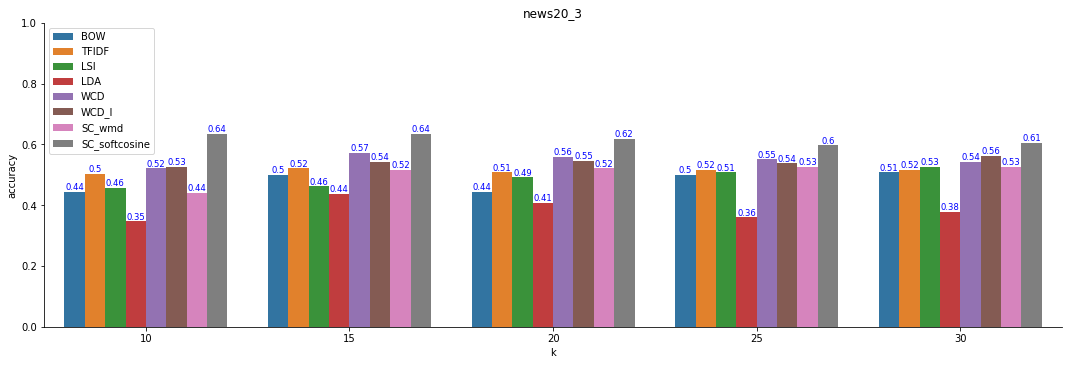

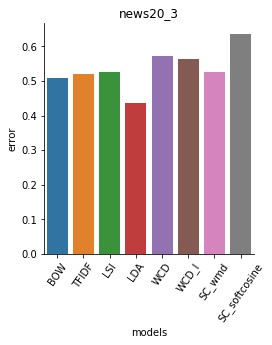

Help on function factorplot in module seaborn.categorical:

factorplot(x=None, y=None, hue=None, data=None, row=None, col=None, col_wrap=None, estimator=<function mean at 0x10ed27ea0>, ci=95, n_boot=1000, units=None, order=None, hue_order=None, row_order=None, col_order=None, kind='point', size=4, aspect=1, orient=None, color=None, palette=None, legend=True, legend_out=True, sharex=True, sharey=True, margin_titles=False, facet_kws=None, **kwargs)
    Draw a categorical plot onto a FacetGrid.
    
    The default plot that is shown is a point plot, but other seaborn
    categorical plots can be chosen with the ``kind`` parameter, including
    box plots, violin plots, bar plots, or strip plots.
    
    It is important to choose how variables get mapped to the plot structure
    such that the most important comparisons are easiest to make. As a general
    rule, it is easier to compare positions that are closer together, so the
    ``hue`` variable should be used for the most important 

In [72]:
classicals = ["BOW", "TFIDF", "LSI", "LDA"]
WCDs = ["WCD", "WCD_I"]
#KMs = ["KM_wmd",  "KM_softcosine"]
DSCs = ["SC_wmd",  "SC_softcosine"]
#names_datasets = ["BBCNews", "BBCNews_4", "BBCNews_3", "BBCNews_2","BBCSport_4", "Newsgroup_4"]
names_datasets = ["news20_3"]
names = classicals+WCDs+DSCs

for i, results in enumerate(results_per_dataset):
    df_all = pd.DataFrame()
    for k, accuracy_per_k in zip(k_values, results):
        #max_accuracies = 1-np.amax(result, axis = 0)
        #max_accuracies = max_accuracies
        #accuracy = 1-np.array(accuracy_per_k)
        accuracy = accuracy_per_k
        #zipped = zip(accuracy, names)
        #sort =  sorted(zip(accuracy,names), reverse = True)
        #sort_err = [e for e,_ in sort]
        #sort_name = [n for _,n in sort]
        df = pd.DataFrame({"accuracy": accuracy, "models": names, "k":accuracy})
        df["k"] = [k]*len(accuracy)
        df_all = df_all.append(df)
    figure(num=None, figsize=(4, 2), dpi=140, facecolor='w', edgecolor='k')
    sns.factorplot(x="k", legend = False, y="accuracy", data=df_all, hue = "models", order = None,kind = "bar", size = 5, aspect = 3)
    ax = plt.gca()
    # ylim max value to be set
    y_max = 1
    ax.set_ylim([0, 1])
    # Iterate through the list of axes' patches
    accs = df_all["accuracy"].tolist()
    for j, p in enumerate(ax.patches):
        ax.text(p.get_x() + p.get_width()/2., p.get_height(),  round(p.get_height(),2),
                fontsize=8.5, color='blue', ha='center', va='bottom')
    plt.xticks(rotation=0)
    plt.title(names_datasets[i])
    plt.legend(loc="upper left")
    plt.title(names_datasets[i])
    plt.show()      
      
for i, result in enumerate(results_per_dataset):
    avg_acc =np.max(result, axis = 0)
    #avg_acc = 1-avg_acc
    #zipped = zip(accuracy, names)
    #sort =  sorted(zip(avg_acc,names), reverse = True)
    #sort_err = [e for e,_ in sort]
    #sort_name = [n for _,n in sort]
    df = pd.DataFrame({"error": avg_acc, "models": names})
    ax = sns.factorplot(x="models", y="error", data=df, aspect = 1, kind = "bar" )
    plt.xticks(rotation=55)
    plt.title(names_datasets[i])
    plt.show()
help(sns.factorplot)
#for x in accuracies:
 #   print(x)
#for report in classification_reports:
 #   print(report[-1])
#for accuracy in accuraciesT:
 #   plt.bar(range(len(accuracy)), accuracy)
  #  plt.show()

In [4]:
#pickle.dump(results_per_dataset, open("benchmark1.pickle", "wb"))
results_saved =pickle.load(open("benchmark1.pickle", "rb"))

In [42]:
0.82726423902894486, 0.86554621848739499, 0.86274509803921573, 
0.83660130718954251, 0.88982259570494859, 0.7796451914098973, 0.83846872082166202
print(X_train[0].indices)
print(common)
print(X_train[3].indices)
0.91616766467065869

NameError: name 'X_train' is not defined

In [47]:
a = [1,2,3,4]
a[[1,2,3]]

TypeError: list indices must be integers or slices, not list

In [ ]:
def wad(text):
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
    text = text.translate(translator).lower().split()
    text = [t for t in text if not t in stopwords.words("english")]
    return np.mean([word2vec[w] for w in text if w in word2vec], axis=0)

def wordcount(text):
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
    text = text.translate(translator).lower().split()
    text = [t for t in text if t in word2vec]
    return len(list(set(text)))
def build_vec_auto(text, cls, strategy):
    """build vector represenetation of text
        cls: Clustering model
        strategy: used with spectral clustering 
            0: non-empy clusters, positive silhoutte scores, weighted average
            1: 
    """
    x = text
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space    
    text = text.translate(translator).lower().split()
    start = time.time()
    text = [t for t in text if t in word2vec and not t in stopwords.words("english")]
    if cls == "kmeans":
        num_clusters = math.ceil(np.sqrt(len(set(text))))
        vecs = [word2vec[w] for w in text]
        km = KMeans(n_clusters = num_clusters, random_state=3425, precompute_distances = True)
        km.fit(vecs)
        non_empty_clusters = np.array(list(set(km.labels_)))
        indices = [np.where(sc.labels_ == i) if i in non_empty_clusters 
                                                               else [] for i in range(num_clusters)]
        
        sizes = np.array([sum(word_counts[indices[i]]) for i in non_empty_clusters])
        sizes_weights = sizes/sum(sizes)
        cluster_sizes = np.array([len(np.where(km.labels_ == i)[0]) for i in range(num_clusters)])
        weights = cluster_sizes/sum(cluster_sizes)
        
        return np.concatenate([[num_clusters], km.cluster_centers_.flatten(), weights])
    elif cls == "spectral":
        if strategy == 0:
            word_counter = Counter(text)
            unique_text = list(word_counter.keys())
            word_counts = np.array(list(word_counter.values()))
            if len(unique_text) < 3:
                unique_text = unique_text*2
                word_counts = word_counts*2
            num_clusters = math.ceil(np.sqrt(len(unique_text)))
            vecs = np.array([word2vec[w] for w in unique_text])
            sc = SpectralClustering(num_clusters, affinity='precomputed', random_state=3425,
                                    assign_labels = "discretize", n_init=100)
            similarity_matrix = cosine_similarity(vecs)+1
            sc.fit(similarity_matrix)
            silhoutte_scores = silhouette_samples(2-similarity_matrix, sc.labels_, metric = 'precomputed')
            non_empty_clusters = np.array(list(set(sc.labels_)))
            indices = [np.where(sc.labels_ == i) if i in non_empty_clusters 
                                                               else [] for i in range(num_clusters)]
            sh_means = np.array([np.mean(silhoutte_scores[indices[i]]) for i in non_empty_clusters])
            pos_sh_means_indices = np.where(sh_means > 0)
            sh_means = sh_means[pos_sh_means_indices]
            good_clusters = non_empty_clusters[pos_sh_means_indices]
            sh_weights = np.array(sh_means/sum(sh_means))
            
            sizes = np.array([sum(word_counts[indices[i]]) for i in good_clusters])
            sizes_weights = sizes/sum(sizes)
            p = 0.3
            weights = p*sh_weights+(1-p)*sizes_weights
            #print("{},{},{}".format(sum(sh_weights), sum(sizes_weights), sum(weights)))
            centroids = np.array([np.mean(vecs[indices[i]], axis = 0) for i in good_clusters])
            rep = np.concatenate(([len(good_clusters)], centroids.flatten(), sizes_weights))
            return rep
        elif strategy == 1:
            word_counter = Counter(text)
            unique_text = list(word_counter.keys())
            word_counts = list(word_counter.values())
            if len(unique_text) < 3:
                unique_text = unique_text*2
                word_counts = word_counts*2
            num_clusters = math.ceil(np.sqrt(len(unique_text)))
            vecs = [word2vec[w] for w in unique_text]
            sc = SpectralClustering(num_clusters, affinity='precomputed', random_state=3425,
                                    assign_labels = "discretize", n_init=100)
            similarity_matrix = cosine_similarity(vecs)+1
            sc.fit(similarity_matrix)
            silhoutte_scores = silhouette_samples(2-similarity_matrix, sc.labels_, metric = 'precomputed')
            silhoutte_contribution = np.multiply(word_counts, silhoutte_scores)
            total_contribution = sum(silhoutte_contribution)
            non_empty_clusters = list(set(sc.labels_))
            indices = [np.where(sc.labels_ == i)[0].tolist() if i in non_empty_clusters 
                                                               else [] for i in range(num_clusters)]
            
            weights = np.array([sum(np.take(silhoutte_contribution, indices[i]))/total_contribution
                                                                        for i in non_empty_clusters])
            #print("{},{},{}".format(sum(sh_weights), sum(sizes_weights), sum(final_weights)))
            centroids = np.array([np.mean(np.take(vecs, indices[i], axis = 0), axis = 0) for i in non_empty_clusters])
            rep = np.concatenate([[len(non_empty_clusters)], centroids.flatten(), weights])
            #for i in range(len(weights)):
             #   print(weights[i])
              #  print(np.take(unique_text, indices[non_empty_clusters[i]]))
            #print("-----")
            return rep
        elif strategy == 2:
            word_counter = Counter(text)
            unique_text = list(word_counter.keys())
            word_counts = list(word_counter.values())
            if len(unique_text) < 3:
                unique_text = unique_text*2
                word_counts = word_counts*2
            num_clusters = 10#math.ceil(np.sqrt(len(unique_text)))
            vecs = [word2vec[w] for w in unique_text]
            sc = SpectralClustering(num_clusters, affinity='precomputed', random_state=3425,
                                    assign_labels = "discretize", n_init=100)
            similarity_matrix = cosine_similarity(vecs)+1
            sc.fit(similarity_matrix)
            non_empty_clusters = list(set(sc.labels_))
            indices = [np.where(sc.labels_ == i)[0].tolist() if i in non_empty_clusters 
                                                               else [] for i in range(num_clusters)]
            sizes = np.array([sum(np.take(word_counts, indices[i])) for i in non_empty_clusters])
            centroids = np.array([np.mean(np.take(vecs, indices[i], axis = 0), axis = 0) for i in non_empty_clusters])
            rep = np.concatenate([[len(non_empty_clusters)], centroids.flatten(), [1/len(sizes)]*len(sizes)])
            return rep

def cluster_TSCD_auto(a, b):
    def euclidean(a, b):
        return np.sqrt(np.sum(np.square(a-b)))
    start = time.time()
    num_clusters_a, num_clusters_b = int(a[0]), int(b[0])
    cut_a, cut_b = 1+300*num_clusters_a, 1+300*num_clusters_b
    topics1, topics2 = a[1:cut_a].reshape(-1,300), b[1:cut_b].reshape(-1,300)
    weights1, weights2 = a[cut_a:cut_a+num_clusters_a], b[cut_b:cut_b+num_clusters_b]
    allTopics = np.concatenate([topics1,topics2])
    d1 = np.concatenate([weights1,[0]*len(topics2)])
    d2 = np.concatenate([[0]*len(topics1),weights2])
    similarity_matrix = cosine_similarity(allTopics)
    result = d1.T.dot(similarity_matrix).dot(d2)
    vec1 = d1.T.dot(similarity_matrix).dot(d1)
    vec2 = d2.T.dot(similarity_matrix).dot(d2)
    result /= (np.sqrt(vec1)*np.sqrt(vec2))
    #print(time.time()-start)
    return np.clip(1-result, 0 , 1)

def cluster_TSCD(a, b, num_clusters):
    def euclidean(a, b):
        return np.sqrt(np.sum(np.square(a-b)))
    cut = 300*num_clusters
    topics1, topics2 = a[0:cut].reshape(-1,300), b[0:cut].reshape(-1,300)
    freq1, freq2 = a[cut:], b[cut:]
    allTopics = np.concatenate([topics1,topics2])
    
    d1 = np.concatenate([freq1/sum(freq1),[0]*len(topics2)])
    d2 = np.concatenate([[0]*len(topics1),freq2/sum(freq2)])
    similarity_matrix = np.ones((len(allTopics), len(allTopics)), np.float64)
    for i in range(1, len(allTopics)):
        for j in range(i):
            #distance_matrix[i, j] = euclidean(allTopics[i], allTopics[j])
            similarity_matrix[i, j] = 1-cosine(allTopics[i], allTopics[j])
            similarity_matrix[j, i] = similarity_matrix[i, j]
    result = d1.T.dot(similarity_matrix).dot(d2)
    vec1 = d1.T.dot(similarity_matrix).dot(d1)
    vec2 = d2.T.dot(similarity_matrix).dot(d2)
    result /= (np.sqrt(vec1)*np.sqrt(vec2))
    return np.clip(1-result, 0, 1)

def cluster_TSCD_raw(text1, text2, num_clusters):
    return cluster_TSCD(build_vec(text1, num_clusters), build_vec(text2, num_clusters), num_clusters)

def cluster_TSCD_raw_auto(text1, text2, cls, strategy):
    return cluster_TSCD_auto(build_vec_auto(text1, cls, strategy), build_vec_auto(text2, cls, strategy))

x = build_vec_auto(texts[-1], "spectral", 0)
x

In [ ]:
mydata = news20_all
train_X, test_X, train_y, test_y = train_test_split(mydata.data, mydata.target, test_size=0.3, random_state=42)
print("started KNN ")
start = time.time()
algo = "wad"
if algo == "wad":
    train_vecs = [ wad(t) for t in train_X]
    test_vecs = [ wad(t) for t in test_X]
elif algo == "LSA":
    LsaVectorizer = make_pipeline(TfidfVectorizer(max_features = 20000, use_idf = True, min_df=2)
                              ,TruncatedSVD(300))
    train_vecs = LsaVectorizer.fit_transform(train_X)
    test_vecs = LsaVectorizer.transform(test_X)
elif algo == "TSCD":
    train_vecs = [ build_vec_auto(t, 'kmeans', 2) for t in train_X]
    test_vecs = [ build_vec_auto(t, 'kmeans', 2) for t in test_X]
    max_len = np.max(np.concatenate(([len(a) for a in train_vecs], [len(a) for a in test_vecs])))
    train_vecs = np.asarray([np.pad(a, (0, max_len - len(a)), 'constant', constant_values=0) for a in train_vecs])
    test_vecs = np.asarray([np.pad(a, (0, max_len - len(a)), 'constant', constant_values=0) for a in test_vecs])
print(time.time() - start)
print("Vectorization finished")

In [ ]:
if algo != "TSCD":
    nbrs = GridSearchCV(KNeighborsClassifier(algorithm='ball_tree'), cv = None, 
                    param_grid={"n_neighbors": range(5,20,5)})
else:
    nbrs = KNeighborsClassifier(algorithm='ball_tree', n_neighbors = 10,
                                metric=lambda a,b: cluster_TSCD_auto(a, b))
nbrs.fit(train_vecs, train_y)
print(time.time() - start)
start = time.time()
#test_vecs = [build_vec(t, num_clusters) for t in news20_test.data]

print("started predicting")
start = time.time()
predicted = nbrs.predict(test_vecs)
print(accuracy_score(predicted, test_y))

In [319]:
print(BBCNews.data[0])
tokenizer = CountVectorizer().build_analyzer()
train = ["ing bank", "bbingbb bank", "lidl"]
test = ["domesti"]
def char_bulk_transformer(texts):
    return [" ".join(t).join(t.lower().split()) for t in texts]
train_trans = char_bulk_transformer(train)
test_trans = char_bulk_transformer(test)
print(train_trans)
INGDumper = make_pipeline(CountVectorizer(ngram_range =(1,4), analyzer = 'char', stop_words=None), 
                              Normalizer(norm = 'l1', copy = False), 
                              TruncatedSVD(20))
train_vecs = INGDumper.fit_transform(train_trans)
test_vecs = INGDumper.transform(test_trans)
tree = BallTree(train_vecs, leaf_size=2)              
dist, ind = tree.query(test_vecs, k=3) 
print(train[ind[0][0]])

UK economy facing 'major risks'

The UK manufacturing sector will continue to face "serious challenges" over the next two years, the British Chamber of Commerce (BCC) has said.

The group's quarterly survey of companies found exports had picked up in the last three months of 2004 to their best levels in eight years. The rise came despite exchange rates being cited as a major concern. However, the BCC found the whole UK economy still faced "major risks" and warned that growth is set to slow. It recently forecast economic growth will slow from more than 3% in 2004 to a little below 2.5% in both 2005 and 2006.

Manufacturers' domestic sales growth fell back slightly in the quarter, the survey of 5,196 firms found. Employment in manufacturing also fell and job expectations were at their lowest level for a year.

"Despite some positive news for the export sector, there are worrying signs for manufacturing," the BCC said. "These results reinforce our concern over the sector's persistent inab

-0.88047579732
-0.814413231819


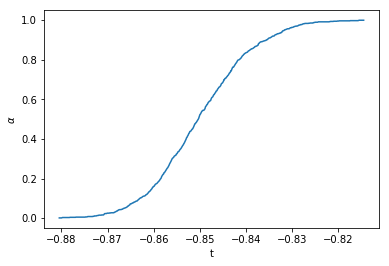

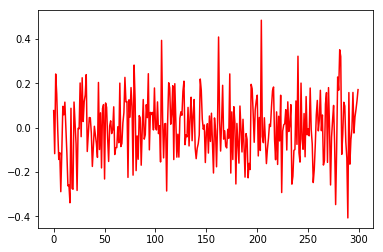

In [657]:
dimension = 300
x = [[random.uniform(-0.1,0) for j in range(dimension)] for i in range(1000)]
centroid =[random.uniform(0.1,0.2) for j in range(dimension)] 
dist = cosine_similarity(x, [centroid])
#dist = euclidean_distances(x, [centroid])
dist = dist.ravel()
#print(dist)
#dist = euclidean_distances(x_vecs, [mean])
res = zip(dist, x)
sort_res = sorted(res,key=lambda res:res[0], reverse=True)
flags = np.array([(t in x) for _, t in sort_res])
flags = np.array([1]*len(dist))
#print(flags)
#for x in sort_res: print(x)
sorted_score = np.array([s for s, _ in sort_res])
sorted_words = np.array([w for _, w in sort_res])
#print(sorted_words[-1])
#print(sorted_score[-1])
#print(sort_res)
percents = []
xr = np.arange(min(sorted_score),max(sorted_score),0.0001)
for thresh in xr:
    cut = flags[np.where(sorted_score <= thresh)]
    sc = 0 if len(cut) == 0 else (sum(cut))/len(x)
    percents.append(sc)
print(min(sorted_score))
print(max(sorted_score))
#print([w for s,w in sort_res if s > 0.65 and w in swords])
#df = pd.DataFrame(dict(x = np.arange(0,1,0.005), score=percents))

#sns.lmplot("x",'score', data=df, fit_reg=False)
plt.plot(xr, percents)
plt.xlabel("t")
plt.ylabel(r"$\alpha$")
plt.show()

plt.plot(word2vec["red"]-stopwords_mean,color = "red")
#plt.hist(word2vec["the"], color = "green", bins = np.arange(-0.2,0.2,0.01))
plt.show()

### 

In [42]:
print([[1,2,3]]+[[2,3,4]])

[[1, 2, 3], [2, 3, 4]]


In [56]:
print(max(1,2))

2


In [28]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.2.4.
The scikit-learn version is 0.19.2.


In [71]:
a = np.array([[1,2,3],[2,3,4]])
b = np.array([0.1,0.2,0.3])
c = b*a
print(np.array([1,2,3])*0.1)

[ 0.1  0.2  0.3]


In [58]:
word2vec.values[:10]

AttributeError: 'Word2VecKeyedVectors' object has no attribute 'values'

In [222]:
n = 2
k = 2
for it in range(10):
    ws = [np.random.rand(n) for i in range(k)]
    c = np.random.rand(n)
    left = sum([np.log(1/(1+np.exp(np.inner(w,c)))) for w in ws])
    right = np.log(1/(1+np.exp(np.inner(np.mean(ws, axis = 0),c)))) * len(ws)
    print("{0:.20f}:{1:.20f}".format(left, right))

-2.61412632494338614819:-2.61012001036739071935
-2.17099497732529211902:-2.16897059824207794065
-2.09003654060507759738:-2.07574640646185981652
-1.64319107358975258215:-1.64121533268962926932
-2.28893596919345920782:-2.27817866320134587710
-2.74225205612611766526:-2.71232655661114874235
-2.04047782167510716178:-2.01269316236395567898
-1.82372422372008902158:-1.82351816052231163745
-1.71653600503356296159:-1.71222887098878584489
-1.74941684482327275418:-1.74741092747888515646


In [194]:
print(np.random.rand(3))

[ 0.78564903  0.91116683  0.45279951]


In [213]:
w = [0.1,0.2,0.1,0.2,0.3]
c = [0.2,0.3,0.5,0.4,0.6]
print(np.log(1/(1+np.exp(np.inner(w,c)))))
print(np.log(1/(1+np.exp(np.inner(np.mean(ws, axis = 0),c)))))

-0.907040396695
-0.907040396695


In [211]:
left = 1
right = 2
print("{}:{}".format(left, right))

1:2


In [26]:
vocab = list(word2vec.vocab.keys())

In [58]:
print(word2vec.similarity("the", "this"))
print(word2vec.similarity("the", "since"))
print(word2vec.similarity("the", "business"))
print(sorted_scores[1])
print(sorted_words[1])

0.593737853085
0.321843315298
0.0918186997544
0.593738
this


In [46]:
scores = [word2vec.similarity(word,"the") for word in vocab]

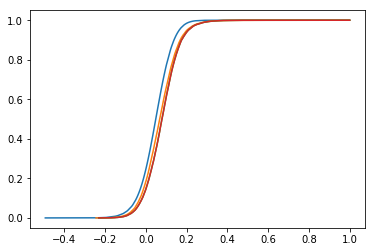

-0.493083307969
1.0


In [78]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
 
    # Number of data points: n
    n=len(data)
 
    # x-data for the ECDF: x
    x=np.sort(data)
 
    # y-data for the ECDF: y
    y=np.arange(1,n+1)/n
 
    return x, y
x, y = ecdf(scores)
plt.plot(x,y)
x, y = ecdf(sport)
plt.plot(x,y)
bbc = sorted_score
x, y = ecdf(bbc)
plt.plot(x,y)
news20 = sorted_score
x, y = ecdf(sorted_score)
plt.plot(x,y)
plt.show()
wpercents = []
sorted_scores = sorted(scores)
wxr = np.arange(min(scores), max(scores),0.01)
print(min(scores))
print(max(scores))
k = 1
pers = []
for i, score in enumerate(sorted_scores):
    if score >k*0.01:
        pers.append(i/len(scores))
        k = k+1

#percents = percents


In [87]:
print(len(sport))
print(len(wxr))
print(len(pers))
x, y = ecdf(scores)
popt, pcov = curve_fit(logistic, x, y)
print(popt)

24864
150
52
[ 0.04845649  0.04251726]


In [60]:
print(word2vec.similar_by_vector(vec_c_all, topn = 100))

[('http_dol##.net_index###.html_http', 0.9355260133743286), ('dol##.net_index####.html_http_dol##.net', 0.9297374486923218), ('index###.html_http_dol##.net_index###.html', 0.9273356795310974), ('By_TRICIA_SCRUGGS', 0.9272603392601013), ('BY_STEFANIE_WHITE', 0.9260945320129395), ('BY_GEOFF_KOHL', 0.9215406775474548), ('http_dol##.net_index####.html_http', 0.9200567603111267), ('SIX_ROG_VX', 0.9199996590614319), ('dol##.net_index###.html_http_dol##.net', 0.9196153283119202), ('REYNOLDS_GALLERY', 0.919133186340332), ('Park_Debate_Colester', 0.9189960360527039), ('By_Ted_Holteen', 0.9188137650489807), ('Emil_Protalinski_Published', 0.9177500009536743), ('By_ROB_BURGESS', 0.9173658490180969), ('BY_DANNY_GALLAGHER', 0.9151509404182434), ('By_JENNIFER_KOVACS', 0.914551854133606), ('Iljitsch_van_Beijnum_Published', 0.9143356680870056), ('By_Matt_Stacionis', 0.9142980575561523), ('By_SALLY_SPAULDING', 0.9141932129859924), ('under_CorMedix_collaborations', 0.9138799905776978), ('By_QianMian_####